In [ ]:
#@title Imports
import os
from google.colab import drive
#######################
drive.mount('/content/drive')
os.chdir("drive/MyDrive/")
os.getcwd()
!pip install git+https://github.com/huggingface/transformers
!pip install -r requirements.txt # requirements.txt needs to be in the current directory
#######################
import transformers
from transformers import AutoTokenizer,AutoConfig,MBartTokenizer,MBartConfig
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AdamW,
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    MBartTokenizer,
    MBartTokenizerFast,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed,
    MBartConfig
)

from transformers.optimization import (
    AdamW, 
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
from tqdm import tqdm, trange
print(transformers.__version__)
import collections
import math
import os.path
from transformers import MBartForConditionalGeneration as BartForConditionalGeneration_transformers
# from mbart import MBartForConditionalGeneration
from tqdm import tqdm, trange
from transformers import Seq2SeqTrainingArguments,DataCollatorForSeq2Seq,Seq2SeqTrainer
import torch.nn as nn
import torch
import numpy as np
import copy
import math
import random
from typing import List, Optional, Tuple, Union
import warnings
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss



In [12]:
#@title Modified Mbart
import transformers
print(transformers.__version__)
import collections
import math
import os.path
from transformers import MBartForConditionalGeneration as BartForConditionalGeneration_transformers
from tqdm import tqdm, trange
from transformers import Seq2SeqTrainingArguments,DataCollatorForSeq2Seq,Seq2SeqTrainer
import torch.nn as nn
import torch
import numpy as np
import random
import pickle

# coding=utf-8
# Copyright 2021, The Facebook AI Research Team and The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" PyTorch MBART model."""
import copy
import math
import random
from typing import List, Optional, Tuple, Union
import warnings
from typing import Optional, Tuple
import numpy as np
import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import pandas as pd
import numpy as np


from transformers.activations import ACT2FN
from transformers.file_utils import (
    add_code_sample_docstrings,
    add_end_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    replace_return_docstrings,
)
from transformers.modeling_outputs import (
    BaseModelOutput,
    BaseModelOutputWithPastAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    Seq2SeqLMOutput,
    Seq2SeqModelOutput,
    Seq2SeqQuestionAnsweringModelOutput,
    Seq2SeqSequenceClassifierOutput,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import logging
from transformers import MBartConfig
from pathlib import Path


logger = logging.get_logger(__name__)
model_name = 'facebook/mbart-large-en-ro'

_CHECKPOINT_FOR_DOC = model_name
_CONFIG_FOR_DOC = "MBartConfig"
_TOKENIZER_FOR_DOC = "MBartTokenizer"

# Base model docstring
_EXPECTED_OUTPUT_SHAPE = [1, 8, 1024]

# SequenceClassification docstring
_CHECKPOINT_FOR_SEQUENCE_CLASSIFICATION = "hf-internal-testing/tiny-random-mbart"
_SEQ_CLASS_EXPECTED_LOSS = 0.69
_SEQ_CLASS_EXPECTED_OUTPUT = "'LABEL_1'"

# QuestionAsnwering docstring
_CHECKPOINT_FOR_QA = "hf-internal-testing/tiny-random-mbart"
_QA_EXPECTED_LOSS = 3.55
_QA_EXPECTED_OUTPUT = "'? Jim Henson was a'"


MBART_PRETRAINED_MODEL_ARCHIVE_LIST = [
    #using pretrained model
############# changed ########
  'facebook/mbart-large-en-ro',
  "facebook/mbart-large-cc25",
    # See all MBART models at https://huggingface.co/models?filter=mbart
]




def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int):
    """
    Shift input ids one token to the right, and wrap the last non pad token (the <LID> token) Note that MBart does not
    have a single `decoder_start_token_id` in contrast to other Bart-like models.
    """
    # there might be some difference here due to bart
    prev_output_tokens = input_ids.clone()

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    prev_output_tokens.masked_fill_(prev_output_tokens == -100, pad_token_id)

    index_of_eos = (prev_output_tokens.ne(pad_token_id).sum(dim=1) - 1).unsqueeze(-1)
    decoder_start_tokens = prev_output_tokens.gather(1, index_of_eos).squeeze()
    prev_output_tokens[:, 1:] = prev_output_tokens[:, :-1].clone()
    prev_output_tokens[:, 0] = decoder_start_tokens

    return prev_output_tokens


# Copied from transformers.models.bart.modeling_bart._make_causal_mask
def _make_causal_mask(input_ids_shape: torch.Size, dtype: torch.dtype, past_key_values_length: int = 0):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min))
    mask_cond = torch.arange(mask.size(-1))
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)


# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


# Copied from transformers.models.bart.modeling_bart.BartLearnedPositionalEmbedding with Bart->MBart
class MBartLearnedPositionalEmbedding(nn.Embedding):
    """
    This module learns positional embeddings up to a fixed maximum size.
    """

    def __init__(self, num_embeddings: int, embedding_dim: int):
        # MBart is set up so that if padding_idx is specified then offset the embedding ids by 2
        # and adjust num_embeddings appropriately. Other models don't have this hack
        self.offset = 2
        super().__init__(num_embeddings + self.offset, embedding_dim)

    def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
        """`input_ids' shape is expected to be [bsz x seqlen]."""

        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        ).expand(bsz, -1)

        return super().forward(positions + self.offset)

class MBartAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None
        bsz, tgt_len, _ = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned aross GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped, past_key_value


class LearnablePositionalEmbedding(nn.Module):

    def __init__(self,m,d_model=1024):
        super().__init__()
        pe = torch.zeros(m,1,d_model)
        # print (f"PE size {pe.size()}")
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        position = torch.arange(m).unsqueeze(1)
        # print (f" position shape {position.size()}")
        sin,cos = torch.sin(position * div_term.unsqueeze(0)) , torch.cos(position * div_term.unsqueeze(0))
        pe[:, 0, 0::2] = sin #even
        pe[:, 0, 1::2] = cos #odd
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return x


class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self,config, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.ff1 = nn.Linear(input_dim, hidden_dim) 
        self.activation = ACT2FN[config.activation_function]
        self.ff2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        ## LINEAR
        out = self.ff1(x)
        out = self.activation(out)
        out = self.ff2(out)
        return out


class learnToRemember(nn.Module):
    def __init__(self, config, memoryType=""):
        super().__init__()
        self.memoryType = memoryType
        self.d_model = config.d_model
        self.memorySize = config.memorySize
        self.dropout = config.dropout
        self.encoder_attention_heads = config.encoder_attention_heads
        self.updateAttn = MBartAttention(
            embed_dim=self.d_model,
            num_heads=self.encoder_attention_heads,
            dropout=self.dropout,
        )
        self.outputAttn = MBartAttention(
            embed_dim=self.d_model,
            num_heads=self.encoder_attention_heads,
            dropout=self.dropout
        )
        self.contextQ = None
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.dropout
        self.ffn = FeedforwardNeuralNetModel(config,input_dim=self.d_model,hidden_dim=config.hiddenDim,output_dim=self.d_model)
        self.lpe = LearnablePositionalEmbedding(self.memorySize)
        self.layerNorm = nn.LayerNorm(config.d_model)
        #memory initialize with 
        self.initMem = nn.Parameter(nn.init.xavier_normal_(torch.randn(1, self.memorySize , config.d_model)))

    def batchInit(self, batch_size):
        return self.initMem.repeat(batch_size, 1, 1)

    def cacheMem(self,newMemoryMatrix,printOut=True):
      if self.memoryType =="en":
        if os.path.exists("oldMem.pt"):
            loaded = torch.load('oldMem.pt')
            previousMemEn = loaded['Memory']
            if printOut:
              print(f"Memory Type : {self.memoryType}")
              print (self.isCorrectMemory(previousMemEn,self.contextQ))
              print (f"Prev Context  :  {self.contextQ}") 
              print (f"Updated Context : {newMemoryMatrix}")
            tensorMem = {'Memory': newMemoryMatrix}
            torch.save(tensorMem, 'oldMem.pt')
        else:
            tensorMem = {'Memory': newMemoryMatrix}
            torch.save(tensorMem, 'oldMem.pt')
      if self.memoryType =="de":
        if os.path.exists("oldMemDe.pt"):
            loaded = torch.load('oldMemDe.pt')
            previousMemEn = loaded['Memory']
            if printOut:
              print(f"Memory Type : {self.memoryType}")
              print (self.isCorrectMemory(previousMemEn,self.contextQ))
              print (f"Prev Context  :  {self.contextQ}") 
              print (f"Updated Context : {newMemoryMatrix}")
            tensorMem = {'Memory': newMemoryMatrix}
            torch.save(tensorMem, 'oldMemDe.pt')
        else:
            tensorMem = {'Memory': newMemoryMatrix}
            torch.save(tensorMem, 'oldMemDe.pt')

    def isCorrectMemory(self,dbMem,currMem):
      return torch.eq(dbMem, currMem)

    def updateMemory(self,memoryMatrix,sentenceState):
      """
      The memory unit is recurrently updated by acquiring information from sentences, 
      and passing the aggregated knowledge back to subsequent sentence states
      """
      #update contextual memory through attention sentence state mapped to Mt through MHA
      skipMemory = memoryMatrix 
      ####Mt = AddNorm(MHA(Mt, ht, ht)) (2)#######
      memoryMatrix, _, _ = self.updateAttn(memoryMatrix, sentenceState)
      memoryMatrix = skipMemory + memoryMatrix #add
      memoryMatrix = self.layerNorm(memoryMatrix)
      #############################################
      # Mt+1 = AddNorm(FeedForward( f Mt))  (3) 
      skipMemory = memoryMatrix 
      memoryMatrix = self.ffn(memoryMatrix)
      memoryMatrix = skipMemory + memoryMatrix
      memoryMatrix = self.layerNorm(memoryMatrix)
      return memoryMatrix
      
    def storeMemory(self,memMatrix):
        # memory stores contextualized information from sentenceState and passes to the next sentence
        self.contextQ = memMatrix.detach()
  
    def forward(self,sentenceState,mask=None,memoryType=""):
          """
          RecMemUnit to supports the infor- mation exchange between the sentence and previous context
          To map the contextualized knowledge from Mt to the sentence state ht, multi-head attention 
          is used to take the representation of ht and Mt as query and key-value, respectively.

          """
          if self.contextQ is None: #check memory Query
              #initialize memory
              self.contextQ = self.batchInit(sentenceState.size()[0]) #batch 
          # the previous information from memory query and k/v comes from currenthiddenstates
          ########### Update ###############
          newMemoryMatrix = self.updateMemory(self.contextQ, sentenceState) #eq (1)
          ##################################
          memoryMatrix = self.contextQ + self.lpe(self.contextQ) #eq (4)
          self.cacheMem(newMemoryMatrix)
          self.storeMemory(newMemoryMatrix)
          # #ht out will be passed to the subsequent modules in the  Transformer layer.
          # ht = MHA(ht, Mt, Mt) #eq (5)
          hT, _, _ = self.outputAttn(sentenceState, memoryMatrix)
          return hT


class MBartEncoderLayer(nn.Module):
    def __init__(self, config: MBartConfig,layer:int):
        super().__init__()
        self.embed_dim = config.d_model
        self.self_attn = MBartAttention(
            embed_dim=self.embed_dim,
            num_heads=config.encoder_attention_heads,
            dropout=config.attention_dropout,
        )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout
        self.fc1 = nn.Linear(self.embed_dim, config.encoder_ffn_dim)
        self.fc2 = nn.Linear(config.encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)
        self.memLayer = config.memLayer
        self.memory = config.Emem
        self.layer = layer
        self.memoryType = "en"
        self.totalLayers = config.encoder_layers
        self.useLTR = False
        if self.memory and self.layer==self.memLayer and self.memLayer < self.totalLayers:
              self.useLTR = True
              self.LTR = learnToRemember(config,self.memoryType) # start of custom
 

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        layer_head_mask: torch.Tensor,
        output_attentions: bool = False,
        original_atention_mask=None,
    ) -> torch.Tensor:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape *(seq_len, batch, embed_dim)*
            attention_mask (`torch.FloatTensor`): attention mask of size
                *(batch, 1, tgt_len, src_len)* where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                *(encoder_attention_heads,)*.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)
        # 1st attention
        hidden_states, attn_weights, _ = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)
        if self.useLTR:
          skipMem = hidden_states
          hidden_states = self.LTR(
              hidden_states,
              original_atention_mask,
              self.memoryType)
          hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
          hidden_states = skipMem + hidden_states
        residual = hidden_states
        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        if hidden_states.dtype == torch.float16 and (
            torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any()
        ):
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)
        outputs = (hidden_states,)
        if output_attentions:
            outputs += (attn_weights,)
        return outputs


class MBartDecoderLayer(nn.Module):
    def __init__(self, config: MBartConfig,layer:int):
        super().__init__()
        self.embed_dim = config.d_model

        self.self_attn = MBartAttention(
            embed_dim=self.embed_dim,
            num_heads=config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = MBartAttention(
            self.embed_dim,
            config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, config.hiddenDim)
        self.fc2 = nn.Linear(config.hiddenDim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)
        self.memLayer = config.memLayer
        self.memory = config.Dmem
        self.isDecoder = True
        self.layer = layer
        self.memoryType = "de"
        self.totalLayers = config.encoder_layers
        self.useLTR = False       
        if self.useMemory():
            self.useLTR = True
            self.LTR = learnToRemember(config,self.memoryType)#start of custom

    def useMemory(self):
        if self.memory and self.layer==self.memLayer and self.memLayer < self.totalLayers:
          return True
        else:
          return False

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = True,
        original_atention_mask: Optional[torch.Tensor] = None,

    ) -> torch.Tensor:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape *(seq_len, batch, embed_dim)*
            attention_mask (`torch.FloatTensor`): attention mask of size
                *(batch, 1, tgt_len, src_len)* where padding elements are indicated by very large negative values.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape *(seq_len, batch, embed_dim)*
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                *(batch, 1, tgt_len, src_len)* where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                *(encoder_attention_heads,)*.
            cross_attn_layer_head_mask (`torch.FloatTensor`): mask for cross-attention heads in a given layer of
                size *(decoder_attention_heads,)*.
            past_key_value (`Tuple(torch.FloatTensor)`): cached past key and value projection states
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None

        if self.useLTR:
          print (f"DECODER ENABLED")
          skip = hidden_states
          hidden_states = self.LTR(
              hidden_states,
              original_atention_mask,
              self.memoryType
          )
          hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
          hidden_states = skip + hidden_states


        if encoder_hidden_states is not None:  

            residual = hidden_states


            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value

        # Fully Connected
        residual = hidden_states
        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs


# Copied from transformers.models.bart.modeling_bart.BartClassificationHead with Bart->MBart
class MBartClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(
        self,
        input_dim: int,
        inner_dim: int,
        num_classes: int,
        pooler_dropout: float,
    ):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=pooler_dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states


class MBartPreTrainedModel(PreTrainedModel):
    config_class = MBartConfig
    base_model_prefix = "model"
    supports_gradient_checkpointing = True

    def _init_weights(self, module):
        std = self.config.init_std
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, (MBartDecoder, MBartDecoder)):
            module.gradient_checkpointing = value

    @property
    def dummy_inputs(self):
        pad_token = self.config.pad_token_id
        input_ids = torch.tensor([[0, 6, 10, 4, 2], [0, 8, 12, 2, pad_token]], device=self.device)
        dummy_inputs = {
            "attention_mask": input_ids.ne(pad_token),
            "input_ids": input_ids,
        }
        return dummy_inputs


MBART_START_DOCSTRING = r"""
    This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
    library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
    etc.)

    This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
    Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
    and behavior.

    Parameters:
        config ([`MBartConfig`]):
            Model configuration class with all the parameters of the model. Initializing with a config file does not
            load the weights associated with the model, only the configuration. Check out the
            [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

MBART_GENERATION_EXAMPLE = r"""
    Translation example:

    ```python
    >>> from transformers import MBartTokenizer, MBartForConditionalGeneration

    >>> model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-en-ro")
    >>> tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-en-ro")

    >>> example_english_phrase = "42 is the answer"
    >>> inputs = tokenizer(example_english_phrase, return_tensors="pt")

    >>> # Translate
    >>> generated_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=5)
    >>> tokenizer.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    '42 este răspuns'
    ```

    Mask filling example:

    ```python
    >>> from transformers import MBartTokenizer, MBartForConditionalGeneration

    >>> model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-cc25")
    >>> tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-cc25")

    >>> # de_DE is the language symbol id <LID> for German
    >>> TXT = "</s> Meine Freunde sind <mask> nett aber sie essen zu viel Kuchen. </s> de_DE"

    >>> input_ids = tokenizer([TXT], add_special_tokens=False, return_tensors="pt")["input_ids"]
    >>> logits = model(input_ids).logits

    >>> masked_index = (input_ids[0] == tokenizer.mask_token_id).nonzero().item()
    >>> probs = logits[0, masked_index].softmax(dim=0)
    >>> values, predictions = probs.topk(5)

    >>> tokenizer.decode(predictions).split()
    ['nett', 'sehr', 'ganz', 'nicht', 'so']
    ```
"""

MBART_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`MBartTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        decoder_input_ids (`torch.LongTensor` of shape `(batch_size, target_sequence_length)`, *optional*):
            Indices of decoder input sequence tokens in the vocabulary.

            Indices can be obtained using [`MBartTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are decoder input IDs?](../glossary#decoder-input-ids)

            MBart uses a specific language id token as the starting token for `decoder_input_ids` generation that
            varies according to source and target language, *e.g.* 25004 for *en_XX*, and 25003 for *de_DE*. If
            `past_key_values` is used, optionally only the last `decoder_input_ids` have to be input (see
            `past_key_values`).

            For translation and summarization training, `decoder_input_ids` should be provided. If no
            `decoder_input_ids` is provided, the model will create this tensor by shifting the `input_ids` to the right
            for denoising pre-training following the paper.
        decoder_attention_mask (`torch.LongTensor` of shape `(batch_size, target_sequence_length)`, *optional*):
            Default behavior: generate a tensor that ignores pad tokens in `decoder_input_ids`. Causal mask will also
            be used by default.
        head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the encoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        decoder_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the decoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the cross-attention modules in the decoder. Mask values selected in `[0,
            1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        encoder_outputs (`tuple(tuple(torch.FloatTensor)`, *optional*):
            Tuple consists of (`last_hidden_state`, *optional*: `hidden_states`, *optional*: `attentions`)
            `last_hidden_state` of shape `(batch_size, sequence_length, hidden_size)`, *optional*) is a sequence of
            hidden-states at the output of the last layer of the encoder. Used in the cross-attention of the decoder.
        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of shape
            `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

            Contains pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`. inputs_embeds (`torch.FloatTensor` of shape
            `(batch_size, sequence_length, hidden_size)`, *optional*): Optionally, instead of passing `input_ids` you
            can choose to directly pass an embedded representation. This is useful if you want more control over how to
            convert `input_ids` indices into associated vectors than the model's internal embedding lookup matrix.
        decoder_inputs_embeds (`torch.FloatTensor` of shape `(batch_size, target_sequence_length, hidden_size)`, *optional*):
            Optionally, instead of passing `decoder_input_ids` you can choose to directly pass an embedded
            representation. If `past_key_values` is used, optionally only the last `decoder_inputs_embeds` have to be
            input (see `past_key_values`). This is useful if you want more control over how to convert
            `decoder_input_ids` indices into associated vectors than the model's internal embedding lookup matrix.

            If `decoder_input_ids` and `decoder_inputs_embeds` are both unset, `decoder_inputs_embeds` takes the value
            of `inputs_embeds`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""


class MBartEncoder(MBartPreTrainedModel):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`MBartEncoderLayer`].

    Args:
        config: MBartConfig
        embed_tokens (nn.Embedding): output embedding
    """

    def __init__(self, config: MBartConfig, embed_tokens: Optional[nn.Embedding] = None):
        super().__init__(config)

        self.dropout = config.dropout
        self.layerdrop = config.encoder_layerdrop

        embed_dim = config.d_model
        self.padding_idx = config.pad_token_id
        self.max_source_positions = config.max_position_embeddings
        self.embed_scale = math.sqrt(embed_dim) if config.scale_embedding else 1.0

        if embed_tokens is not None:
            self.embed_tokens = embed_tokens
        else:
            self.embed_tokens = nn.Embedding(config.vocab_size, embed_dim, self.padding_idx)

        self.embed_positions = MBartLearnedPositionalEmbedding(
            config.max_position_embeddings,
            embed_dim)
        self.layers = nn.ModuleList([MBartEncoderLayer(config,layer) for layer in range(config.encoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(embed_dim)
        self.layer_norm = nn.LayerNorm(config.d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def _backward_compatibility_gradient_checkpointing(self):
        # Override to not delete the attribute from the config
        if self.supports_gradient_checkpointing and getattr(self.config, "gradient_checkpointing", False):
            self.gradient_checkpointing_enable()

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutput]:
        r"""
        Args:
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.

                Indices can be obtained using [`MBartTokenizer`]. See [`PreTrainedTokenizer.encode`] and
                [`PreTrainedTokenizer.__call__`] for details.

                [What are input IDs?](../glossary#input-ids)
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input = input_ids
            input_shape = input.shape
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input = inputs_embeds[:, :, -1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale

        embed_pos = self.embed_positions(input)

        hidden_states = inputs_embeds + embed_pos
        hidden_states = self.layernorm_embedding(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        # check if head_mask has a correct number of layers specified if desired
        if head_mask is not None:
            if head_mask.size()[0] != len(self.layers):
                raise ValueError(
                    f"The head_mask should be specified for {len(self.layers)} layers, but it is for"
                    f" {head_mask.size()[0]}."
                )
        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                if self.gradient_checkpointing and self.training:

                    def create_custom_forward(module):
                        def custom_forward(*inputs):
                            return module(*inputs, output_attentions)

                        return custom_forward

                    layer_outputs = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(encoder_layer),
                        hidden_states,
                        attention_mask,
                        (head_mask[idx] if head_mask is not None else None),
                    )
                else:
                    layer_outputs = encoder_layer(
                        hidden_states,
                        attention_mask,
                        layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                        output_attentions=output_attentions,
                    )

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        hidden_states = self.layer_norm(hidden_states)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )


class MBartDecoder(MBartPreTrainedModel):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`MBartDecoderLayer`]

    Args:
        config: MBartConfig
        embed_tokens (nn.Embedding): output embedding
    """

    def __init__(self, config: MBartConfig, embed_tokens: Optional[nn.Embedding] = None):
        super().__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.decoder_layerdrop
        self.padding_idx = config.pad_token_id
        self.max_target_positions = config.max_position_embeddings
        self.embed_scale = math.sqrt(config.d_model) if config.scale_embedding else 1.0

        if embed_tokens is not None:
            self.embed_tokens = embed_tokens
        else:
            self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model, self.padding_idx)

        self.embed_positions = MBartLearnedPositionalEmbedding(
            config.max_position_embeddings,
            config.d_model,
        )
        self.layers = nn.ModuleList([MBartDecoderLayer(config,layer) for layer in range(config.decoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(config.d_model)
        self.layer_norm = nn.LayerNorm(config.d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    # Copied from transformers.models.bart.modeling_bart.BartDecoder._prepare_decoder_attention_mask
    def _prepare_decoder_attention_mask(self, attention_mask, input_shape, inputs_embeds, past_key_values_length):
        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        combined_attention_mask = None
        if input_shape[-1] > 1:
            combined_attention_mask = _make_causal_mask(
                input_shape, inputs_embeds.dtype, past_key_values_length=past_key_values_length
            ).to(inputs_embeds.device)

        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            expanded_attn_mask = _expand_mask(attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]).to(
                inputs_embeds.device
            )
            combined_attention_mask = (
                expanded_attn_mask if combined_attention_mask is None else expanded_attn_mask + combined_attention_mask
            )

        return combined_attention_mask

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPastAndCrossAttentions]:
        r"""
        Args:
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.

                Indices can be obtained using [`MBartTokenizer`]. See [`PreTrainedTokenizer.encode`] and
                [`PreTrainedTokenizer.__call__`] for details.

                [What are input IDs?](../glossary#input-ids)
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                of the decoder.
            encoder_attention_mask (`torch.LongTensor` of shape `(batch_size, encoder_sequence_length)`, *optional*):
                Mask to avoid performing cross-attention on padding tokens indices of encoder input_ids. Mask values
                selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the cross-attention modules in the decoder to avoid performing
                cross-attention on hidden heads. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
                shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

                Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
                cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

                If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
                that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
                all `decoder_input_ids` of shape `(batch_size, sequence_length)`. inputs_embeds (`torch.FloatTensor` of
                shape `(batch_size, sequence_length, hidden_size)`, *optional*): Optionally, instead of passing
                `input_ids` you can choose to directly pass an embedded representation. This is useful if you want more
                control over how to convert `input_ids` indices into associated vectors than the model's internal
                embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
        elif input_ids is not None:
            input = input_ids
            input_shape = input.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            input = inputs_embeds[:, :, -1]
        else:
            raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale
        original_atention_mask = attention_mask
        attention_mask = self._prepare_decoder_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            encoder_attention_mask = _expand_mask(encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1])

        # embed positions
        positions = self.embed_positions(input, past_key_values_length)

        hidden_states = inputs_embeds + positions
        hidden_states = self.layernorm_embedding(hidden_states)

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
            if attn_mask is not None:
                if attn_mask.size()[0] != len(self.layers):
                    raise ValueError(
                        f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                        f" {head_mask.size()[0]}."
                    )
        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):
                continue

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        # None for past_key_value
                        return module(*inputs, output_attentions, use_cache)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    head_mask[idx] if head_mask is not None else None,
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
                    None,
                )
            else:

                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    cross_attn_layer_head_mask=(
                        cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                    ),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                    original_atention_mask=original_atention_mask,

                )
            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        hidden_states = self.layer_norm(hidden_states)
        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
            cross_attentions=all_cross_attentions,
        )


@add_start_docstrings(
    "The bare MBART Model outputting raw hidden-states without any specific head on top.",
    MBART_START_DOCSTRING,
)
class MBartModel(MBartPreTrainedModel):
    def __init__(self, config: MBartConfig):
        super().__init__(config)

        padding_idx, vocab_size = config.pad_token_id, config.vocab_size
        self.shared = nn.Embedding(vocab_size, config.d_model, padding_idx)

        self.encoder = MBartEncoder(config, self.shared)
        self.decoder = MBartDecoder(config, self.shared)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, value):
        self.shared = value
        self.encoder.embed_tokens = self.shared
        self.decoder.embed_tokens = self.shared

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    @add_start_docstrings_to_model_forward(MBART_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        processor_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=Seq2SeqModelOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output=_EXPECTED_OUTPUT_SHAPE,
    )
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Seq2SeqModelOutput, Tuple[torch.FloatTensor]]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # different to other models, MBart automatically creates decoder_input_ids from
        # input_ids if no decoder_input_ids are provided
        if decoder_input_ids is None and decoder_inputs_embeds is None:
            decoder_input_ids = shift_tokens_right(input_ids, self.config.pad_token_id)

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs[0],
            encoder_attention_mask=attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs + encoder_outputs

        return Seq2SeqModelOutput(
            last_hidden_state=decoder_outputs.last_hidden_state,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )


@add_start_docstrings(
    "The MBART Model with a language modeling head. Can be used for summarization.", MBART_START_DOCSTRING
)
class MBartForConditionalGeneration(MBartPreTrainedModel):
    base_model_prefix = "model"
    _keys_to_ignore_on_load_missing = [
        r"final_logits_bias",
        r"encoder.version",
        r"decoder.version",
        r"lm_head.weight",
    ]

    def __init__(self, config: MBartConfig):
        super().__init__(config)
        self.model = MBartModel(config) # Our model
        self.register_buffer("final_logits_bias", torch.zeros((1, self.model.shared.num_embeddings)))
        self.lm_head = nn.Linear(config.d_model, self.model.shared.num_embeddings, bias=False)

        # Initialize weights and apply final processing
        self.post_init()


    def get_encoder(self):
        return self.model.get_encoder()

    def get_decoder(self):
        return self.model.get_decoder()

    def resize_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        new_embeddings = super().resize_token_embeddings(new_num_tokens)
        self._resize_final_logits_bias(new_num_tokens)
        return new_embeddings

    def _resize_final_logits_bias(self, new_num_tokens: int) -> None:
        old_num_tokens = self.final_logits_bias.shape[-1]
        if new_num_tokens <= old_num_tokens:
            new_bias = self.final_logits_bias[:, :new_num_tokens]
        else:
            extra_bias = torch.zeros((1, new_num_tokens - old_num_tokens), device=self.final_logits_bias.device)
            new_bias = torch.cat([self.final_logits_bias, extra_bias], dim=1)
        self.register_buffer("final_logits_bias", new_bias)

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    @add_start_docstrings_to_model_forward(MBART_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=Seq2SeqLMOutput, config_class=_CONFIG_FOR_DOC)
    @add_end_docstrings(MBART_GENERATION_EXAMPLE)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Seq2SeqLMOutput, Tuple[torch.FloatTensor]]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
            config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
            (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:

        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            if use_cache:
                logger.warning("The `use_cache` argument is changed to `False` since `labels` is provided.")
            use_cache = False
            if decoder_input_ids is None:
                decoder_input_ids = shift_tokens_right(labels, self.config.pad_token_id)

        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            encoder_outputs=encoder_outputs,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        lm_logits = self.lm_head(outputs[0]) + self.final_logits_bias

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(lm_logits.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )

    def prepare_inputs_for_generation(
        self,
        decoder_input_ids,
        past=None,
        attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        use_cache=None,
        encoder_outputs=None,
        **kwargs
    ):
        # cut decoder_input_ids if past is used
        if past is not None:
            decoder_input_ids = decoder_input_ids[:, -1:]

        return {
            "input_ids": None,  # encoder_outputs is defined. input_ids not needed
            "encoder_outputs": encoder_outputs,
            "past_key_values": past,
            "decoder_input_ids": decoder_input_ids,
            "attention_mask": attention_mask,
            "head_mask": head_mask,
            "decoder_head_mask": decoder_head_mask,
            "cross_attn_head_mask": cross_attn_head_mask,
            "use_cache": use_cache,  # change this to avoid caching (presumably for debugging)
        }

    def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
        return shift_tokens_right(labels, self.config.pad_token_id)

    @staticmethod
    def _reorder_cache(past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            # cached cross_attention states don't have to be reordered -> they are always the same
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx) for past_state in layer_past[:2]) + layer_past[2:],
            )
        return reordered_past


@add_start_docstrings(
    """
    MBart model with a sequence classification/head on top (a linear layer on top of the pooled output) e.g. for GLUE
    tasks.
    """,
    MBART_START_DOCSTRING,
)
class MBartForSequenceClassification(MBartPreTrainedModel):
    def __init__(self, config: MBartConfig, **kwargs):
        super().__init__(config, **kwargs)
        self.model = MBartModel(config)
        self.classification_head = MBartClassificationHead(
            config.d_model,
            config.d_model,
            config.num_labels,
            config.classifier_dropout,
        )
        self.model._init_weights(self.classification_head.dense)
        self.model._init_weights(self.classification_head.out_proj)

    @add_start_docstrings_to_model_forward(MBART_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        processor_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_SEQUENCE_CLASSIFICATION,
        output_type=Seq2SeqSequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output=_SEQ_CLASS_EXPECTED_OUTPUT,
        expected_loss=_SEQ_CLASS_EXPECTED_LOSS,
    )
    # Copied from transformers.models.bart.modeling_bart.BartForSequenceClassification.forward
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, Seq2SeqSequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        if labels is not None:
            use_cache = False

        if input_ids is None and inputs_embeds is not None:
            raise NotImplementedError(
                f"Passing input embeddings is currently not supported for {self.__class__.__name__}"
            )

        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            encoder_outputs=encoder_outputs,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]  # last hidden state

        eos_mask = input_ids.eq(self.config.eos_token_id)

        if len(torch.unique_consecutive(eos_mask.sum(1))) > 1:
            raise ValueError("All examples must have the same number of <eos> tokens.")
        sentence_representation = hidden_states[eos_mask, :].view(hidden_states.size(0), -1, hidden_states.size(-1))[
            :, -1, :
        ]
        logits = self.classification_head(sentence_representation)

        loss = None
        if labels is not None:
            # if self.config.problem_type is None:
            if self.config.num_labels == 1:
            #         self.config.problem_type = "regression"
            #     elif self.config.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
            #         self.config.problem_type = "single_label_classification"
            #     else:
            #         self.config.problem_type = "multi_label_classification"

            # if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                # if self.config.num_labels == 1:
                loss = loss_fct(logits.squeeze(), labels.squeeze())
                # else:
                #     loss = loss_fct(logits, labels)
            # elif self.config.problem_type == "single_label_classification":
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))
            # elif self.config.problem_type == "multi_label_classification":
            #     loss_fct = BCEWithLogitsLoss()
            #     loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return Seq2SeqSequenceClassifierOutput(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )


@add_start_docstrings(
    """
    MBART Model with a span classification head on top for extractive question-answering tasks like SQuAD (a linear
    layer on top of the hidden-states output to compute `span start logits` and `span end logits`).
    """,
    MBART_START_DOCSTRING,
)
class MBartForQuestionAnswering(MBartPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        config.num_labels = 2
        self.num_labels = config.num_labels

        self.model = MBartModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

        self.model._init_weights(self.qa_outputs)

    @add_start_docstrings_to_model_forward(MBART_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        processor_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_QA,
        output_type=Seq2SeqQuestionAnsweringModelOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_loss=_QA_EXPECTED_LOSS,
        expected_output=_QA_EXPECTED_OUTPUT,
    )
    # Copied from transformers.models.bart.modeling_bart.BartForQuestionAnswering.forward
    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[List[torch.FloatTensor]] = None,
        start_positions: Optional[torch.LongTensor] = None,
        end_positions: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, Seq2SeqQuestionAnsweringModelOutput]:
        r"""
        start_positions (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (*sequence_length*). Position outside of the sequence
            are not taken into account for computing the loss.
        end_positions (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (*sequence_length*). Position outside of the sequence
            are not taken into account for computing the loss.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        if start_positions is not None and end_positions is not None:
            use_cache = False

        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            encoder_outputs=encoder_outputs,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits = end_logits.squeeze(-1).contiguous()

        total_loss = None
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions = start_positions.clamp(0, ignored_index)
            end_positions = end_positions.clamp(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
            output = (
                start_logits,
                end_logits,
            ) + outputs[1:]
            return ((total_loss,) + output) if total_loss is not None else output

        return Seq2SeqQuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )


# Copied from transformers.models.bart.modeling_bart.BartDecoderWrapper with Bart->MBart
class MBartDecoderWrapper(MBartPreTrainedModel):
    """
    This wrapper class is a helper class to correctly load pretrained checkpoints when the causal language model is
    used in combination with the [`EncoderDecoderModel`] framework.
    """

    def __init__(self, config):
        super().__init__(config)
        self.decoder = MBartDecoder(config)

    def forward(self, *args, **kwargs):
        return self.decoder(*args, **kwargs)


# Copied from transformers.models.bart.modeling_bart.BartForCausalLM with Bart->MBart, facebook/bart-base->facebook/mbart-large-cc25
class MBartForCausalLM(MBartPreTrainedModel):
    def __init__(self, config):
        config = copy.deepcopy(config)
        config.is_decoder = True
        config.is_encoder_decoder = False
        super().__init__(config)
        self.model = MBartDecoderWrapper(config)

        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.decoder.embed_tokens

    def set_input_embeddings(self, value):
        self.model.decoder.embed_tokens = value

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def set_decoder(self, decoder):
        self.model.decoder = decoder

    def get_decoder(self):
        return self.model.decoder

    @replace_return_docstrings(output_type=CausalLMOutputWithCrossAttentions, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, CausalLMOutputWithCrossAttentions]:
        r"""
        Args:
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.

                Indices can be obtained using [`MBartTokenizer`]. See [`PreTrainedTokenizer.encode`] and
                [`PreTrainedTokenizer.__call__`] for details.

                [What are input IDs?](../glossary#input-ids)
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                if the model is configured as a decoder.
            encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used
                in the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:
            head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the cross-attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
                shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`. The two additional
                tensors are only required when the model is used as a decoder in a Sequence to Sequence model.

                Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
                cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

                If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
                that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
                all `decoder_input_ids` of shape `(batch_size, sequence_length)`.
            labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
                config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
                (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.

        Returns:

        Example:

        ```python
        >>> from transformers import MBartTokenizer, MBartForCausalLM

        >>> tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-cc25")
        >>> model = MBartForCausalLM.from_pretrained("facebook/mbart-large-cc25", add_cross_attention=False)
        >>> assert model.config.is_decoder, f"{model.__class__} has to be configured as a decoder."
        >>> inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
        >>> outputs = model(**inputs)

        >>> logits = outputs.logits
        >>> expected_shape = [1, inputs.input_ids.shape[-1], model.config.vocab_size]
        >>> list(logits.shape) == expected_shape
        True
        ```"""

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            head_mask=head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        logits = self.lm_head(outputs[0])

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    def prepare_inputs_for_generation(self, input_ids, past=None, attention_mask=None, use_cache=None, **kwargs):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_ids.shape)

        if past:
            input_ids = input_ids[:, -1:]
        # first step, decoder_cached_states are empty
        return {
            "input_ids": input_ids,  # encoder_outputs is defined. input_ids not needed
            "attention_mask": attention_mask,
            "past_key_values": past,
            "use_cache": use_cache,
        }

    @staticmethod
    def _reorder_cache(past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            reordered_past += (tuple(past_state.index_select(0, beam_idx) for past_state in layer_past),)
        return reordered_past




4.24.0.dev0


In [13]:
#@title CustomModel and Training Loop
import matplotlib.pyplot as plt
import random,numpy as np,torch
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


class CustomModel(nn.Module):
    def __init__(self, config, memLayer=None):
        super().__init__()
        self.config = config
        self.model = MBartForConditionalGeneration(config)

    def forward(self, input_ids, attention_mask, decoder_input_ids=None,decoder_start_token_id=None, decoder_attention_mask=None, labels=None,label_ids=None, print_path=None, return_dict_in_generate=False):
        output = self.model(input_ids, attention_mask, decoder_input_ids, decoder_attention_mask, labels=labels)
        return output[0]

    def clearCache(self):
        oldMem = "oldMem.pt"
        if os.path.exists("oldMem.pt"):
          os.remove(oldMem)
          print(f"{oldMem} has been removed successfully!")

    def resetMem(self,printOut=False):
      self.clearCache()
      if self.config.memLayer != None :
        if self.config.Emem:
          print (f"Before Encoder LTR Memory : {self.model.model.encoder.layers[self.config.memLayer].LTR.contextQ}") if printOut else None
          self.model.model.encoder.layers[self.config.memLayer].LTR.contextQ = None
          print (f"After Encoder LTR update Memory : {self.model.model.encoder.layers[self.config.memLayer].LTR.contextQ}") if printOut else None
        if self.config.Dmem:
          print (f"Before Decoder LTR Memory : {self.model.model.decoder.layers[self.config.memLayer].LTR.contextQ}") if printOut else None
          self.model.model.decoder.layers[self.config.memLayer].LTR.contextQ = None
          print (f"After Decoder LTR update Memory : {self.model.model.decoder.layers[self.config.memLayer].LTR.contextQ}") if printOut else None


def Train(epochs,model):
  lossDelta = []
  lossCounter = []
  #########"Toy Doument"###########
  trainDataloader = [
  { "ro": "Componenţa Parlamentului: a se vedea procesul-verbal", "en": "Membership of Parliament: see Minutes" },
  { "ro": "Aprobarea procesului-verbal al şedinţei precedente: a se vedea procesul-verbal", "en": "Approval of Minutes of previous sitting: see Minutes" },
  { "ro": "Componenţa Parlamentului: a se vedea procesul-verbal", "en": "Membership of Parliament: see Minutes" },
  { "ro": "Verificarea prerogativelor: a se vedea procesul-verbal", "en": "Verification of credentials: see Minutes" },
  { "ro": "Depunere de documente: a se vedea procesul-verbal", "en": "Documents received: see Minutes" },
  { "ro": "Declaraţii scrise şi întrebări orale (depunere): consultaţi procesul-verbal", "en": "Written statements and oral questions (tabling): see Minutes" },
  { "ro": "Petiţii: a se vedea procesul-verbal", "en": "Petitions: see Minutes" },
  { "ro": "Transmiterea de către Consiliu a textelor acordurilor: a se vedea procesul-verbal", "en": "Texts of agreements forwarded by the Council: see Minutes" },
  { "ro": "Cursul dat rezoluţiilor Parlamentului: a se vedea procesul-verbal", "en": "Action taken on Parliament's resolutions: see Minutes" },
  { "ro": "Ordinea de zi a următoarei şedinţe: a se vedea procesul-verbal", "en": "Agenda for next sitting: see Minutes" },
  { "ro": "Ridicarea şedinţei", "en": "Closure of sitting" },
  { "ro": "(Se levanta la sesión a las 19.45 horas)", "en": "(The sitting was closed at 7.45 p.m.)" },
  { "ro": "Alegerea vicepreşedinţilor Parlamentului European (termenul de depunere a candidaturilor): consultaţi procesul-verbal", "en": "Election of Vice-Presidents of the European Parliament (deadline for submitting nominations): see Minutes" },
  { "ro": "(Die Sitzung wird um 12.40 Uhr unterbrochen und um 15.00 Uhr wiederaufgenommen).", "en": "(The sitting was suspended at 12.40 p.m. and resumed at 3.00 p.m.)" },
  { "ro": "Alegerea chestorilor Parlamentului European (termenul de depunere a candidaturilor): consultaţi procesul-verbal", "en": "Election of Quaestors of the European Parliament (deadline for submitting nominations): see Minutes" },
  { "ro": "(Die Sitzung wird um 15.25 Uhr unterbrochen und um 18.00 Uhr wiederaufgenommen).", "en": "(The sitting was suspended at 3.25 p.m. and resumed at 6.00 p.m.)" },
  { "ro": "Ordinea de zi a următoarei şedinţe: a se vedea procesul-verbal", "en": "Agenda for next sitting: see Minutes" },
  { "ro": "Ridicarea şedinţei", "en": "Closure of sitting" },
  { "ro": "(Die Sitzung wird um 18.15 Uhr geschlossen.)", "en": "(The sitting was closed at 6.15 p.m.)" },
  { "ro": "Deschiderea şedinţei", "en": "Opening of the sitting" }
  ]
  ###Reset Memory before each document run##########
  model.resetMem(printOut=True)
  ##################################################

  num_train_epochs = epochs
  running_loss = 0.0
  progress_bar = tqdm(range(num_train_epochs))
  train_loss = 0.0
  prev_loss = 0.0
  for epoch in range(num_train_epochs):
    prev_loss,running_loss = train_loss , 0.0
    print (f"New epoch loss {running_loss}")
    for i,val in enumerate(trainDataloader):
      print (f"Sentence {i} in Document")
      example_english_phrase = val['en']
      expected_translation_romanian = val["ro"]
      inputs = tokenizer(example_english_phrase, text_target=expected_translation_romanian, return_tensors="pt")
      inputs = inputs.to(device)
      model.to(device)
      model.train()
      # # forward pass
      loss = model(**inputs)
      loss.backward(retain_graph=True)
      optimizer.step()
      running_loss += loss.item()     
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar.update(1)
    train_loss=running_loss/len(trainDataloader)
    print (f"This is the epoch loss {train_loss}")
    delta = prev_loss - train_loss
    lossCounter.append(train_loss)
    lossDelta.append(delta)
    delta = 0
  #####ResetMemory After Document#############
  return lossCounter,lossDelta

def plotLoss(losses):
    # plot lines
    plt.plot(losses, label = "memory")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()


In [14]:
#@title Setup Parameters

model_name = 'facebook/mbart-large-en-ro'
device = torch.device("cuda")
######Seed######
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
##########################Tokenizer #####
learning_rate = 3e-04
dataset_config_name = "ro-en"
source_lang = "en_XX"
target_lang= "ro_RO"
tokenizer = MBartTokenizer.from_pretrained(model_name,use_fast=True)
tokenizer.src_lang = source_lang
tokenizer.tgt_lang = target_lang
#################################################
"""
Custom configs
Emem = Boolean for activating Encoder memory 
Dmem = Boolean for activating Decoder memory 
"""
config = MBartConfig(vocab_size=tokenizer.vocab_size, d_model=1024, encoder_ffn_dim=2048,decoder_ffn_dim=2048, hiddenDim=2048,
                            pad_token_id=0, bos_token_id=1, eos_token_id=2, decoder_start_token_id=1, encoder_layers=6,
                            decoder_layers=6, encoder_attention_heads=8, decoder_attention_heads=8, dropout=0.3,
                            attention_dropout=0.3,memorySize=16,memLayer=5,Emem=True,Dmem=False,beam=5,device=device)

warmup_steps = 1000 
config.vocab_size=tokenizer.vocab_size
config.decoder_start_token_id = tokenizer.lang_code_to_id[target_lang]
model = CustomModel(config, config.memLayer)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.01,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=5000)

# model

In [15]:
epochs = 5
lossCounter,lossDelta = Train(epochs,model)
lossCounter,lossDelta

Before Encoder LTR Memory : None
After Encoder LTR update Memory : None


  0%|          | 0/5 [00:00<?, ?it/s]

New epoch loss 0.0
Sentence 0 in Document


 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

Sentence 1 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 1.3047, -0.6593,  1.0881,  ...,  1.6752,  0.1769,  0.0996],
         [ 0.5201, -0.5946,  0.5588,  ...,  1.9231, -0.3792,  0.8786],
         [ 0.6478, -0.3716,  0.7114,  ...,  2.0064,  0.4074,  0.3954],
         ...,
         [ 0.7009, -1.2375,  0.0339,  ...,  1.7149,  0.1511,  0.9952],
         [ 0.5252, -1.1252,  1.1495,  ...,  1.1116, -0.3828,  0.6873],
         [ 0.2125, -0.4336,  1.0203,  ...,  1.4679,  0.9545, -0.4286]]],
       device='cuda:0')
Updated Context : tensor([[[ 1.0577, -0.7558,  0.4452,  ...,  1.6768,  0.3137, -0.3471],
         [ 0.2014, -0.7879, -0.1533, 

 40%|████      | 2/5 [00:00<00:01,  2.23it/s]

Sentence 2 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 1.0577, -0.7558,  0.4452,  ...,  1.6768,  0.3137, -0.3471],
         [ 0.2014, -0.7879, -0.1533,  ...,  1.7891, -0.0747,  0.6464],
         [ 0.6165, -0.7891,  0.1123,  ...,  1.6734,  0.4768,  0.3150],
         ...,
         [ 0.6542, -1.4748, -0.1823,  ...,  1.4509,  0.3783,  0.7778],
         [ 0.4580, -1.5300,  0.7519,  ...,  0.9343, -0.2008,  0.6530],
         [ 0.1135, -0.7236,  0.2994,  ...,  1.2123,  0.8617, -0.3364]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.8596, -0.6878,  0.0586,  ...,  1.2484,  0.4043, -0.4072],
         [ 0.0446, -0.8175, -0.4769, 

 60%|██████    | 3/5 [00:01<00:00,  2.74it/s]

Sentence 3 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.8596, -0.6878,  0.0586,  ...,  1.2484,  0.4043, -0.4072],
         [ 0.0446, -0.8175, -0.4769,  ...,  1.1783,  0.2228,  0.7107],
         [ 0.6471, -0.9190, -0.2050,  ...,  1.0642,  0.5710,  0.4933],
         ...,
         [ 0.6785, -1.3581, -0.2838,  ...,  0.9223,  0.6742,  0.5503],
         [ 0.4739, -1.4619,  0.4709,  ...,  0.4749, -0.0486,  0.7817],
         [ 0.0791, -0.8210, -0.1004,  ...,  0.7154,  0.7598,  0.0552]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2383, -0.8202, -0.0859,  ...,  1.0369,  0.4434, -0.1882],
         [-0.2133, -1.0111, -0.6316, 

 80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

Sentence 4 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2383, -0.8202, -0.0859,  ...,  1.0369,  0.4434, -0.1882],
         [-0.2133, -1.0111, -0.6316,  ...,  0.8354,  0.4195,  0.7861],
         [ 0.2544, -0.9631, -0.3269,  ...,  0.6782,  0.4394,  0.6528],
         ...,
         [ 0.3269, -1.3274, -0.3805,  ...,  0.6431,  0.6894,  0.6027],
         [ 0.2073, -1.3396,  0.2982,  ...,  0.2174, -0.2184,  0.8289],
         [-0.0942, -0.8747, -0.2155,  ...,  0.4382,  0.3775,  0.4251]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.1382, -0.7566, -0.0778,  ...,  0.7476,  0.2669,  0.1217],
         [-0.0354, -0.8834, -0.5788, 

100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

Sentence 5 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.1382, -0.7566, -0.0778,  ...,  0.7476,  0.2669,  0.1217],
         [-0.0354, -0.8834, -0.5788,  ...,  0.5479,  0.4066,  0.8472],
         [ 0.3073, -0.8199, -0.3930,  ...,  0.3826,  0.1884,  0.9564],
         ...,
         [ 0.2154, -1.2269, -0.3438,  ...,  0.5154,  0.5593,  0.7038],
         [ 0.0858, -0.9795,  0.2242,  ...,  0.1380, -0.3601,  0.8206],
         [-0.2262, -0.6720, -0.2632,  ...,  0.4254,  0.1512,  0.8096]]],
       device='cuda:0')
Updated Context : tensor([[[-0.0044, -0.4442, -0.0892,  ...,  0.5480,  0.3428,  0.3260],
         [-0.1021, -0.6437, -0.7257, 

6it [00:02,  3.55it/s]                       

Sentence 6 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.0044, -0.4442, -0.0892,  ...,  0.5480,  0.3428,  0.3260],
         [-0.1021, -0.6437, -0.7257,  ...,  0.3330,  0.4040,  1.0130],
         [ 0.2751, -0.5591, -0.3494,  ...,  0.0818,  0.0558,  1.1189],
         ...,
         [ 0.1169, -0.8530, -0.4683,  ...,  0.2644,  0.5857,  0.7998],
         [ 0.1588, -0.4835,  0.0132,  ..., -0.0846, -0.3910,  0.8267],
         [-0.2061, -0.4242, -0.3226,  ...,  0.2252,  0.1879,  0.9685]]],
       device='cuda:0')
Updated Context : tensor([[[-0.0448, -0.3656,  0.1346,  ...,  0.2142,  0.2672,  0.3808],
         [-0.1538, -0.5990, -0.3221, 

7it [00:02,  3.67it/s]

Sentence 7 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.0448, -0.3656,  0.1346,  ...,  0.2142,  0.2672,  0.3808],
         [-0.1538, -0.5990, -0.3221,  ...,  0.2798,  0.3009,  1.1951],
         [ 0.1029, -0.4541, -0.0197,  ..., -0.0963,  0.0040,  1.4417],
         ...,
         [-0.1135, -0.6193, -0.3947,  ...,  0.0694,  0.4852,  0.8755],
         [-0.0699, -0.1384,  0.0431,  ..., -0.1158, -0.4391,  1.1303],
         [-0.2048, -0.4044, -0.0879,  ..., -0.0225,  0.1747,  1.2427]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.0617, -0.2170,  0.0488,  ...,  0.1727,  0.2361,  0.3931],
         [-0.0842, -0.4134, -0.4403, 

8it [00:02,  3.75it/s]

Sentence 8 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.0617, -0.2170,  0.0488,  ...,  0.1727,  0.2361,  0.3931],
         [-0.0842, -0.4134, -0.4403,  ...,  0.1423,  0.2526,  1.0839],
         [ 0.1712, -0.3475, -0.0848,  ..., -0.1248, -0.0336,  1.2583],
         ...,
         [ 0.0632, -0.5149, -0.3594,  ..., -0.0401,  0.4533,  0.7748],
         [ 0.0165,  0.0792, -0.1127,  ..., -0.1884, -0.3510,  1.0414],
         [-0.0952, -0.2989, -0.2191,  ...,  0.0169,  0.0620,  1.1705]]],
       device='cuda:0')
Updated Context : tensor([[[-0.2001, -0.1557,  0.1025,  ...,  0.1892,  0.1690,  0.6184],
         [-0.1827, -0.3941, -0.3833, 

9it [00:02,  3.80it/s]

Sentence 9 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.2001, -0.1557,  0.1025,  ...,  0.1892,  0.1690,  0.6184],
         [-0.1827, -0.3941, -0.3833,  ...,  0.2653,  0.1756,  1.2543],
         [ 0.0427, -0.3044,  0.0532,  ..., -0.1178, -0.1003,  1.4379],
         ...,
         [-0.1980, -0.5022, -0.3054,  ...,  0.1243,  0.3789,  1.0029],
         [-0.1258,  0.1320, -0.1504,  ..., -0.1289, -0.5019,  1.1617],
         [-0.1998, -0.2416, -0.2140,  ...,  0.0693, -0.0811,  1.4095]]],
       device='cuda:0')
Updated Context : tensor([[[-0.1212,  0.0018,  0.4119,  ...,  0.1267,  0.2267,  0.7058],
         [-0.1639, -0.0552,  0.0204, 

10it [00:03,  3.84it/s]

Sentence 10 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.1212,  0.0018,  0.4119,  ...,  0.1267,  0.2267,  0.7058],
         [-0.1639, -0.0552,  0.0204,  ...,  0.3098,  0.1416,  1.0987],
         [ 0.0649, -0.2412,  0.5460,  ..., -0.1603,  0.0249,  1.4351],
         ...,
         [-0.0473, -0.4320,  0.2614,  ...,  0.1265,  0.4481,  1.0262],
         [-0.1587,  0.3054,  0.2278,  ..., -0.2047, -0.4954,  1.2358],
         [-0.2066, -0.0469,  0.2292,  ...,  0.0262, -0.0884,  1.3937]]],
       device='cuda:0')
Updated Context : tensor([[[-0.2788,  0.2263,  0.1164,  ...,  0.1458,  0.0824,  0.6961],
         [-0.1184,  0.2664, -0.1190,

11it [00:03,  3.83it/s]

Sentence 11 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.2788,  0.2263,  0.1164,  ...,  0.1458,  0.0824,  0.6961],
         [-0.1184,  0.2664, -0.1190,  ...,  0.3349,  0.1602,  1.0580],
         [ 0.0650, -0.1353,  0.3066,  ..., -0.1719,  0.0396,  1.3925],
         ...,
         [-0.1607, -0.1917,  0.0819,  ...,  0.1432,  0.5783,  1.0725],
         [-0.2119,  0.2941, -0.1082,  ..., -0.2495, -0.4615,  1.1757],
         [-0.1677, -0.0183,  0.1348,  ..., -0.0524, -0.2107,  1.4726]]],
       device='cuda:0')
Updated Context : tensor([[[-3.1256e-01,  3.5334e-01,  2.4991e-02,  ...,  4.5022e-01,
           5.9954e-02,  7.6079e-01],
  

12it [00:03,  3.86it/s]

Sentence 12 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-3.1256e-01,  3.5334e-01,  2.4991e-02,  ...,  4.5022e-01,
           5.9954e-02,  7.6079e-01],
         [-5.9759e-02,  3.4116e-01, -1.7887e-01,  ...,  5.5072e-01,
           1.3356e-01,  9.6977e-01],
         [ 1.3500e-01,  3.5703e-02,  1.8522e-01,  ...,  6.2209e-02,
           9.5405e-03,  1.3376e+00],
         ...,
         [ 4.7007e-03, -1.5121e-01,  1.6062e-01,  ...,  2.2893e-01,
           5.6403e-01,  1.0223e+00],
         [-1.5264e-01,  4.1568e-01, -2.8654e-01,  ...,  3.2112e-04,
          -3.1073e-01,  1.1556e+00],
         [-1.2018e-01,  1.5218e-01,  5.1439e-02,  ..

13it [00:03,  3.86it/s]

Sentence 13 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.2250,  0.6081,  0.0344,  ...,  0.3502, -0.1463,  0.7004],
         [ 0.0071,  0.6536, -0.2492,  ...,  0.5503, -0.1987,  0.9330],
         [ 0.2383,  0.3523,  0.1178,  ...,  0.1521, -0.1587,  1.2219],
         ...,
         [ 0.0877,  0.1603,  0.1035,  ...,  0.3648,  0.3800,  1.0250],
         [-0.0801,  0.7280, -0.4477,  ..., -0.0067, -0.5247,  1.1669],
         [-0.0091,  0.5027, -0.0509,  ...,  0.1487, -0.3034,  1.3686]]],
       device='cuda:0')
Updated Context : tensor([[[-0.3521,  0.7638, -0.0897,  ...,  0.1911, -0.2005,  0.7834],
         [ 0.0107,  0.8345, -0.2899,

14it [00:04,  3.86it/s]

Sentence 14 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.3521,  0.7638, -0.0897,  ...,  0.1911, -0.2005,  0.7834],
         [ 0.0107,  0.8345, -0.2899,  ...,  0.4514, -0.2349,  1.0460],
         [ 0.0897,  0.4572, -0.0154,  ...,  0.0593, -0.2391,  1.2509],
         ...,
         [ 0.0079,  0.4528, -0.0578,  ...,  0.3468,  0.2685,  1.1129],
         [-0.1202,  0.9271, -0.6749,  ..., -0.0469, -0.5706,  1.1746],
         [-0.0386,  0.7311, -0.1113,  ...,  0.0834, -0.2823,  1.3582]]],
       device='cuda:0')
Updated Context : tensor([[[-0.4681,  1.0257, -0.1570,  ...,  0.2082, -0.3212,  0.6964],
         [-0.0379,  1.2328, -0.3317,

15it [00:04,  3.87it/s]

Sentence 15 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.4681,  1.0257, -0.1570,  ...,  0.2082, -0.3212,  0.6964],
         [-0.0379,  1.2328, -0.3317,  ...,  0.3176, -0.4048,  0.9291],
         [-0.0363,  0.7047, -0.1526,  ...,  0.0935, -0.3947,  1.0607],
         ...,
         [ 0.0334,  0.8888, -0.1262,  ...,  0.4186,  0.1766,  0.9710],
         [-0.1584,  1.2525, -0.6335,  ..., -0.0537, -0.5933,  0.9698],
         [-0.0901,  1.0023, -0.1875,  ...,  0.0912, -0.4487,  1.2008]]],
       device='cuda:0')
Updated Context : tensor([[[-0.5111,  1.2286, -0.1055,  ...,  0.0928, -0.1798,  0.7063],
         [ 0.0060,  1.4140, -0.2063,

16it [00:04,  3.89it/s]

Sentence 16 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.5111,  1.2286, -0.1055,  ...,  0.0928, -0.1798,  0.7063],
         [ 0.0060,  1.4140, -0.2063,  ...,  0.3440, -0.3345,  0.9141],
         [-0.1041,  0.8477, -0.1241,  ...,  0.1267, -0.2314,  1.0619],
         ...,
         [-0.0131,  1.1120, -0.1068,  ...,  0.4691,  0.1555,  0.8972],
         [-0.2480,  1.4914, -0.4926,  ..., -0.0521, -0.4212,  0.8770],
         [-0.1945,  1.1953, -0.1666,  ...,  0.1548, -0.3498,  1.1324]]],
       device='cuda:0')
Updated Context : tensor([[[-0.5102,  1.2607, -0.1092,  ..., -0.0364, -0.0487,  0.7845],
         [-0.1723,  1.4045, -0.0982,

17it [00:04,  3.90it/s]

Sentence 17 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.5102,  1.2607, -0.1092,  ..., -0.0364, -0.0487,  0.7845],
         [-0.1723,  1.4045, -0.0982,  ...,  0.3395, -0.4348,  0.9340],
         [-0.1877,  0.8777, -0.1223,  ...,  0.0716, -0.2616,  1.1190],
         ...,
         [-0.0941,  1.0861, -0.0721,  ...,  0.5082,  0.2514,  0.9905],
         [-0.3049,  1.4926, -0.3826,  ..., -0.0700, -0.3144,  0.9267],
         [-0.3778,  1.1213, -0.1797,  ...,  0.0798, -0.2881,  1.2442]]],
       device='cuda:0')
Updated Context : tensor([[[-3.1112e-01,  1.2709e+00, -3.1904e-01,  ..., -8.3002e-02,
          -1.2032e-01,  5.1310e-01],
  

18it [00:05,  3.81it/s]

Sentence 18 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-3.1112e-01,  1.2709e+00, -3.1904e-01,  ..., -8.3002e-02,
          -1.2032e-01,  5.1310e-01],
         [-1.2722e-01,  1.3168e+00, -4.8268e-01,  ...,  3.4377e-01,
          -3.5875e-01,  6.7246e-01],
         [-4.0983e-02,  8.1674e-01, -6.0106e-01,  ...,  3.8505e-04,
          -1.7759e-01,  8.1615e-01],
         ...,
         [-4.1956e-02,  9.7759e-01, -1.4073e-02,  ...,  3.4581e-01,
           3.5838e-01,  6.0469e-01],
         [-1.3683e-01,  1.3357e+00, -5.2991e-01,  ..., -8.5751e-02,
          -3.0712e-01,  5.4564e-01],
         [-2.4722e-01,  1.1730e+00, -4.5597e-01,  ..

19it [00:05,  3.81it/s]

Sentence 19 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.2628,  1.0948, -0.3219,  ...,  0.1824, -0.1300,  0.3388],
         [-0.0862,  1.1868, -0.3294,  ...,  0.4049, -0.1906,  0.4872],
         [-0.0500,  0.6686, -0.6074,  ...,  0.3576, -0.0790,  0.6788],
         ...,
         [-0.0549,  0.9383,  0.0603,  ...,  0.5632,  0.3535,  0.5458],
         [-0.0960,  1.1449, -0.4938,  ...,  0.1297, -0.1980,  0.3343],
         [-0.3246,  1.1146, -0.5234,  ...,  0.3662, -0.2610,  0.6920]]],
       device='cuda:0')
Updated Context : tensor([[[-0.1019,  1.1885, -0.1665,  ..., -0.0426, -0.0887,  0.3514],
         [ 0.0119,  1.2269, -0.0560,

20it [00:05,  3.82it/s]

This is the epoch loss 12.531908416748047
New epoch loss 0.0
Sentence 0 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.1019,  1.1885, -0.1665,  ..., -0.0426, -0.0887,  0.3514],
         [ 0.0119,  1.2269, -0.0560,  ...,  0.3310, -0.1425,  0.5587],
         [ 0.0275,  0.7679, -0.4652,  ...,  0.2184,  0.0426,  0.7595],
         ...,
         [ 0.1005,  1.0866,  0.1290,  ...,  0.5202,  0.4061,  0.6436],
         [ 0.0123,  1.1922, -0.1573,  ...,  0.1425, -0.0931,  0.4412],
         [-0.1519,  1.1347, -0.3469,  ...,  0.3256, -0.1035,  0.7636]]],
       device='cuda:0')
Updated Context : tensor([[[-0.1617,  1.4094, -0.0837,  ..., -0.1

21it [00:05,  3.85it/s]

Sentence 1 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.1617,  1.4094, -0.0837,  ..., -0.1217,  0.1477,  0.3163],
         [-0.0766,  1.3585,  0.0183,  ...,  0.2285,  0.0243,  0.5162],
         [-0.1533,  1.0592, -0.3048,  ...,  0.0623,  0.1959,  0.7679],
         ...,
         [-0.0233,  1.1879,  0.2230,  ...,  0.2912,  0.3192,  0.5565],
         [-0.0867,  1.3737, -0.0344,  ..., -0.0556,  0.0543,  0.4231],
         [-0.2725,  1.1766, -0.2733,  ...,  0.1120, -0.0119,  0.5886]]],
       device='cuda:0')
Updated Context : tensor([[[-0.1433,  1.2637,  0.0482,  ..., -0.0771, -0.1004,  0.3735],
         [-0.0841,  1.1503,  0.0944, 

22it [00:06,  3.87it/s]

Sentence 2 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.1433,  1.2637,  0.0482,  ..., -0.0771, -0.1004,  0.3735],
         [-0.0841,  1.1503,  0.0944,  ...,  0.1349,  0.0135,  0.4296],
         [-0.1145,  0.7803, -0.3389,  ...,  0.1352,  0.1172,  0.7345],
         ...,
         [ 0.0105,  0.9311,  0.2321,  ...,  0.3332,  0.3704,  0.5610],
         [-0.0532,  1.2110, -0.0843,  ..., -0.0842, -0.1521,  0.3501],
         [-0.1892,  0.9795, -0.2251,  ...,  0.1559, -0.1231,  0.5278]]],
       device='cuda:0')
Updated Context : tensor([[[-0.0963,  1.2246,  0.2460,  ..., -0.1812,  0.1725,  0.1757],
         [-0.0268,  1.1633,  0.2134, 

23it [00:06,  3.88it/s]

Sentence 3 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.0963,  1.2246,  0.2460,  ..., -0.1812,  0.1725,  0.1757],
         [-0.0268,  1.1633,  0.2134,  ..., -0.0182,  0.2207,  0.2666],
         [-0.0650,  0.8284, -0.2229,  ..., -0.0857,  0.1874,  0.5981],
         ...,
         [ 0.0402,  0.9087,  0.3932,  ...,  0.2020,  0.3863,  0.3339],
         [-0.0159,  1.1853, -0.0626,  ..., -0.2005, -0.0740,  0.1540],
         [-0.1373,  1.0243, -0.0021,  ...,  0.1457, -0.0553,  0.2612]]],
       device='cuda:0')
Updated Context : tensor([[[-0.2556,  1.3848,  0.2150,  ..., -0.0296,  0.1881,  0.1344],
         [-0.2398,  1.1563,  0.3059, 

24it [00:06,  3.89it/s]

Sentence 4 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.2556,  1.3848,  0.2150,  ..., -0.0296,  0.1881,  0.1344],
         [-0.2398,  1.1563,  0.3059,  ...,  0.0062,  0.2521,  0.2137],
         [-0.2220,  0.9112, -0.1037,  ..., -0.0425,  0.1951,  0.5431],
         ...,
         [-0.2817,  0.9485,  0.4694,  ...,  0.1655,  0.2646,  0.1242],
         [-0.1762,  1.2328,  0.1334,  ..., -0.1602, -0.0804,  0.1315],
         [-0.3573,  1.1148,  0.0352,  ...,  0.1553, -0.0726,  0.1146]]],
       device='cuda:0')
Updated Context : tensor([[[-0.0484,  1.2598,  0.4125,  ..., -0.0623,  0.1861,  0.2920],
         [-0.0673,  1.0787,  0.4369, 

25it [00:06,  3.90it/s]

Sentence 5 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.0484,  1.2598,  0.4125,  ..., -0.0623,  0.1861,  0.2920],
         [-0.0673,  1.0787,  0.4369,  ..., -0.1032,  0.2913,  0.4439],
         [-0.0541,  0.7548,  0.0724,  ...,  0.0130,  0.2514,  0.6387],
         ...,
         [-0.1895,  0.8176,  0.6444,  ...,  0.1982,  0.4380,  0.2973],
         [-0.0282,  1.0874,  0.3562,  ..., -0.1571, -0.1015,  0.3253],
         [-0.2859,  0.9420,  0.1624,  ...,  0.2013,  0.0585,  0.1116]]],
       device='cuda:0')
Updated Context : tensor([[[-0.0179,  1.2194,  0.3996,  ..., -0.0826,  0.4440,  0.1539],
         [-0.1056,  1.0160,  0.3560, 

26it [00:07,  3.85it/s]

Sentence 6 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.0179,  1.2194,  0.3996,  ..., -0.0826,  0.4440,  0.1539],
         [-0.1056,  1.0160,  0.3560,  ..., -0.1483,  0.4690,  0.2189],
         [ 0.0491,  0.7349,  0.0235,  ...,  0.1389,  0.3425,  0.4195],
         ...,
         [-0.2199,  0.8640,  0.6241,  ...,  0.1939,  0.4962,  0.0934],
         [ 0.0066,  1.1235,  0.3150,  ..., -0.1678,  0.0345,  0.1049],
         [-0.2494,  0.9924,  0.1214,  ...,  0.1858,  0.2023, -0.0479]]],
       device='cuda:0')
Updated Context : tensor([[[-0.1294,  1.2281,  0.5062,  ...,  0.0948,  0.5820, -0.0142],
         [-0.3356,  0.9694,  0.4782, 

27it [00:07,  3.87it/s]

Sentence 7 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.1294,  1.2281,  0.5062,  ...,  0.0948,  0.5820, -0.0142],
         [-0.3356,  0.9694,  0.4782,  ..., -0.1076,  0.4391,  0.0215],
         [-0.1607,  0.6966,  0.3495,  ...,  0.1539,  0.3452,  0.4368],
         ...,
         [-0.1292,  0.9326,  0.7741,  ...,  0.2993,  0.5839,  0.1097],
         [ 0.1803,  1.1532,  0.5366,  ..., -0.1251,  0.1668, -0.0358],
         [-0.2512,  0.9657,  0.3038,  ...,  0.3420,  0.4342, -0.2921]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.0225,  1.3767,  0.4913,  ..., -0.0176,  0.6196,  0.0713],
         [-0.2073,  1.2810,  0.4232, 

28it [00:07,  3.90it/s]

Sentence 8 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.0225,  1.3767,  0.4913,  ..., -0.0176,  0.6196,  0.0713],
         [-0.2073,  1.2810,  0.4232,  ..., -0.1205,  0.4556,  0.0174],
         [-0.1105,  0.9741,  0.3557,  ...,  0.0970,  0.4540,  0.4855],
         ...,
         [ 0.0123,  1.0640,  0.7245,  ...,  0.3218,  0.6102,  0.1232],
         [ 0.1532,  1.3287,  0.5711,  ..., -0.1578,  0.2758,  0.0019],
         [-0.1642,  1.1974,  0.2905,  ...,  0.2399,  0.4392, -0.1839]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.0294,  1.2962,  0.4689,  ..., -0.0416,  0.6180,  0.3070],
         [-0.2268,  1.2029,  0.3504, 

29it [00:07,  3.92it/s]

Sentence 9 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.0294,  1.2962,  0.4689,  ..., -0.0416,  0.6180,  0.3070],
         [-0.2268,  1.2029,  0.3504,  ..., -0.1466,  0.4858,  0.3436],
         [-0.1394,  0.8916,  0.2970,  ...,  0.1403,  0.5587,  0.6894],
         ...,
         [ 0.0481,  1.0018,  0.6584,  ...,  0.2588,  0.6757,  0.3745],
         [ 0.0521,  1.1802,  0.4851,  ..., -0.2289,  0.3629,  0.2250],
         [-0.1943,  1.0941,  0.1742,  ...,  0.2257,  0.5481,  0.1354]]],
       device='cuda:0')
Updated Context : tensor([[[-0.0931,  1.1906,  0.7182,  ..., -0.1976,  0.6746,  0.4790],
         [-0.2362,  1.2435,  0.5558, 

30it [00:08,  3.93it/s]

Sentence 10 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.0931,  1.1906,  0.7182,  ..., -0.1976,  0.6746,  0.4790],
         [-0.2362,  1.2435,  0.5558,  ..., -0.2482,  0.5696,  0.4405],
         [-0.1710,  0.9395,  0.4742,  ..., -0.0059,  0.7293,  0.7329],
         ...,
         [-0.0116,  0.9627,  0.8870,  ...,  0.0832,  0.6585,  0.4802],
         [ 0.0542,  1.0454,  0.7147,  ..., -0.4184,  0.4700,  0.2370],
         [-0.1154,  0.9916,  0.4572,  ...,  0.1034,  0.6090,  0.1834]]],
       device='cuda:0')
Updated Context : tensor([[[-0.0905,  1.1756,  0.5709,  ..., -0.0156,  0.5116,  0.2208],
         [-0.2226,  1.3121,  0.2708,

31it [00:08,  3.92it/s]

Sentence 11 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[-0.0905,  1.1756,  0.5709,  ..., -0.0156,  0.5116,  0.2208],
         [-0.2226,  1.3121,  0.2708,  ..., -0.0658,  0.4598,  0.3166],
         [-0.2507,  0.9041,  0.6667,  ...,  0.0718,  0.7077,  0.4853],
         ...,
         [ 0.0713,  0.9500,  0.9538,  ...,  0.0981,  0.5146,  0.2862],
         [-0.0945,  1.0126,  0.7451,  ..., -0.1923,  0.5013, -0.0119],
         [-0.0970,  1.0386,  0.4989,  ...,  0.2133,  0.3684, -0.0673]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.0982,  0.9725,  0.5314,  ...,  0.0196,  0.5757,  0.1720],
         [-0.0228,  1.2676,  0.2285,

32it [00:08,  3.92it/s]

Sentence 12 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.0982,  0.9725,  0.5314,  ...,  0.0196,  0.5757,  0.1720],
         [-0.0228,  1.2676,  0.2285,  ..., -0.1035,  0.4873,  0.2379],
         [-0.0612,  0.8466,  0.5278,  ...,  0.0270,  0.7624,  0.4276],
         ...,
         [ 0.2616,  0.9246,  0.7990,  ...,  0.0444,  0.6882,  0.0657],
         [-0.0315,  0.8192,  0.6995,  ..., -0.0935,  0.6104, -0.0719],
         [-0.0374,  0.8511,  0.5294,  ...,  0.1373,  0.5391, -0.1767]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.1654,  1.0633,  0.3472,  ...,  0.0758,  0.4602,  0.2825],
         [ 0.1016,  1.3540,  0.1793,

33it [00:08,  3.91it/s]

Sentence 13 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.1654,  1.0633,  0.3472,  ...,  0.0758,  0.4602,  0.2825],
         [ 0.1016,  1.3540,  0.1793,  ..., -0.0906,  0.3107,  0.3177],
         [ 0.0717,  0.9464,  0.2141,  ...,  0.0823,  0.4496,  0.5375],
         ...,
         [ 0.3282,  1.0854,  0.5215,  ...,  0.1347,  0.4710,  0.2236],
         [ 0.0361,  0.9797,  0.4799,  ..., -0.0400,  0.3776,  0.0751],
         [ 0.0136,  0.9801,  0.2777,  ...,  0.0760,  0.3506,  0.0158]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.1724,  0.8532,  0.2761,  ...,  0.0258,  0.3768,  0.2049],
         [ 0.1105,  1.2021, -0.0533,

34it [00:09,  3.88it/s]

Sentence 14 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.1724,  0.8532,  0.2761,  ...,  0.0258,  0.3768,  0.2049],
         [ 0.1105,  1.2021, -0.0533,  ...,  0.0170,  0.2683,  0.1243],
         [ 0.0312,  0.9260, -0.0226,  ...,  0.0902,  0.3839,  0.4099],
         ...,
         [ 0.2699,  1.0377,  0.3735,  ...,  0.1108,  0.4239,  0.0756],
         [ 0.0621,  0.8977,  0.2792,  ...,  0.0389,  0.3614, -0.1045],
         [ 0.0380,  0.8163,  0.0502,  ...,  0.1413,  0.3528, -0.0496]]],
       device='cuda:0')
Updated Context : tensor([[[ 1.2585e-01,  9.5345e-01,  1.7093e-01,  ..., -9.6475e-03,
           2.9659e-01,  2.5905e-01],
  

35it [00:09,  3.87it/s]

Sentence 15 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 1.2585e-01,  9.5345e-01,  1.7093e-01,  ..., -9.6475e-03,
           2.9659e-01,  2.5905e-01],
         [ 9.6169e-02,  1.2287e+00, -1.8903e-03,  ..., -7.2126e-03,
           2.2831e-01,  1.2374e-01],
         [-5.0859e-02,  1.0229e+00, -1.4711e-01,  ...,  5.2797e-02,
           3.2756e-01,  4.0927e-01],
         ...,
         [ 2.0991e-01,  1.1579e+00,  2.6885e-01,  ...,  3.5541e-03,
           3.5069e-01,  1.4638e-01],
         [-2.0475e-02,  1.0358e+00,  2.2197e-01,  ..., -9.5200e-03,
           3.1704e-01,  7.2868e-04],
         [-3.0357e-02,  9.0886e-01,  3.3631e-02,  ..

36it [00:09,  3.88it/s]

Sentence 16 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.1943,  0.7829,  0.1068,  ...,  0.2652,  0.2302,  0.0684],
         [ 0.1167,  1.0801,  0.0551,  ...,  0.0954,  0.2125, -0.0148],
         [-0.0190,  0.8999, -0.2117,  ...,  0.0668,  0.2408,  0.2206],
         ...,
         [ 0.1400,  1.0678,  0.3149,  ...,  0.1546,  0.3127, -0.0491],
         [ 0.0148,  0.8484,  0.1951,  ...,  0.1800,  0.2732, -0.1453],
         [-0.0401,  0.8276,  0.2071,  ...,  0.1626,  0.3298, -0.2001]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.1466,  0.7259,  0.0784,  ...,  0.4547,  0.1365,  0.0483],
         [ 0.0620,  1.0677,  0.2359,

37it [00:09,  3.81it/s]

Sentence 17 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.1466,  0.7259,  0.0784,  ...,  0.4547,  0.1365,  0.0483],
         [ 0.0620,  1.0677,  0.2359,  ...,  0.2735,  0.3497, -0.0921],
         [-0.0152,  0.9817, -0.1728,  ...,  0.1585,  0.1834,  0.1846],
         ...,
         [ 0.2009,  1.1151,  0.3163,  ...,  0.3728,  0.1065, -0.0510],
         [ 0.0684,  0.8908,  0.3770,  ...,  0.3709,  0.1524, -0.1081],
         [-0.0371,  0.7826,  0.3562,  ...,  0.3129,  0.1910, -0.1464]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.1242,  0.6722,  0.2368,  ...,  0.4143,  0.3042, -0.3442],
         [ 0.0430,  0.8304,  0.4843,

38it [00:10,  3.81it/s]

Sentence 18 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.1242,  0.6722,  0.2368,  ...,  0.4143,  0.3042, -0.3442],
         [ 0.0430,  0.8304,  0.4843,  ...,  0.2331,  0.5496, -0.4830],
         [-0.0446,  0.8824, -0.0338,  ...,  0.2785,  0.2901, -0.1117],
         ...,
         [ 0.1563,  0.8656,  0.2678,  ...,  0.3465,  0.2286, -0.3067],
         [ 0.0581,  0.8093,  0.3666,  ...,  0.4543,  0.1481, -0.1450],
         [-0.1538,  0.6008,  0.5547,  ...,  0.3501,  0.3165, -0.5976]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2480,  0.5273,  0.1987,  ...,  0.4735,  0.1268, -0.1939],
         [ 0.0558,  0.7374,  0.4505,

39it [00:10,  3.85it/s]

Sentence 19 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2480,  0.5273,  0.1987,  ...,  0.4735,  0.1268, -0.1939],
         [ 0.0558,  0.7374,  0.4505,  ...,  0.1388,  0.2753, -0.4809],
         [ 0.0823,  0.6761, -0.1710,  ...,  0.4594, -0.0307,  0.0914],
         ...,
         [ 0.0993,  0.6725,  0.2561,  ...,  0.2989,  0.0396, -0.2663],
         [ 0.0461,  0.6156,  0.3747,  ...,  0.5747, -0.1106, -0.0272],
         [-0.0911,  0.5334,  0.5974,  ...,  0.4426,  0.0994, -0.3816]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4776,  0.6642,  0.3410,  ...,  0.4266,  0.0390, -0.4074],
         [ 0.0647,  0.6949,  0.6613,

40it [00:10,  3.83it/s]

This is the epoch loss 11.60353193283081
New epoch loss 0.0
Sentence 0 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4776,  0.6642,  0.3410,  ...,  0.4266,  0.0390, -0.4074],
         [ 0.0647,  0.6949,  0.6613,  ...,  0.1158,  0.2485, -0.6634],
         [ 0.3576,  0.8511,  0.0371,  ...,  0.3360, -0.0633, -0.0445],
         ...,
         [ 0.2332,  0.7982,  0.4020,  ...,  0.2239, -0.0606, -0.4977],
         [ 0.1377,  0.7676,  0.4866,  ...,  0.4593, -0.0335, -0.1722],
         [ 0.1065,  0.5695,  0.8274,  ...,  0.2583, -0.0313, -0.6099]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4959,  0.6281,  0.3855,  ...,  0.33

41it [00:11,  3.86it/s]

Sentence 1 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4959,  0.6281,  0.3855,  ...,  0.3319,  0.0759, -0.2100],
         [ 0.1826,  0.6708,  0.5806,  ...,  0.0695,  0.1863, -0.4990],
         [ 0.4828,  0.8771, -0.0450,  ...,  0.2859, -0.0905,  0.1820],
         ...,
         [ 0.1183,  0.8749,  0.3750,  ...,  0.1867,  0.0611, -0.1735],
         [ 0.1178,  0.7203,  0.4444,  ...,  0.2169,  0.0587, -0.0860],
         [ 0.1268,  0.6581,  0.7425,  ...,  0.2371, -0.1167, -0.3481]]],
       device='cuda:0')
Updated Context : tensor([[[ 3.3133e-01,  6.2010e-01,  4.0457e-01,  ...,  3.3678e-01,
           1.4996e-01, -1.9825e-01],
   

42it [00:11,  3.85it/s]

Sentence 2 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 3.3133e-01,  6.2010e-01,  4.0457e-01,  ...,  3.3678e-01,
           1.4996e-01, -1.9825e-01],
         [ 2.8579e-01,  6.9686e-01,  5.3766e-01,  ...,  6.6129e-02,
           2.9688e-01, -5.9289e-01],
         [ 5.0270e-01,  8.0556e-01, -7.0069e-02,  ...,  3.2326e-01,
          -2.9463e-04,  5.0396e-02],
         ...,
         [ 1.9713e-01,  6.9772e-01,  4.5660e-01,  ...,  2.5503e-01,
           2.2151e-01, -2.3958e-01],
         [ 9.6078e-02,  7.9195e-01,  3.3166e-01,  ...,  3.4178e-01,
           1.3572e-01, -2.1542e-01],
         [ 1.3541e-01,  8.2734e-01,  5.8420e-01,  ...

43it [00:11,  3.86it/s]

Sentence 3 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5561,  0.1898,  0.6671,  ...,  0.4937,  0.2281, -0.0194],
         [ 0.4792,  0.2648,  0.6128,  ...,  0.2463,  0.3642, -0.4450],
         [ 0.4661,  0.3207,  0.0967,  ...,  0.3755,  0.1366,  0.1343],
         ...,
         [ 0.3792,  0.3131,  0.6650,  ...,  0.4167,  0.2624, -0.0949],
         [ 0.2883,  0.4120,  0.4375,  ...,  0.4852,  0.1594, -0.0846],
         [ 0.3463,  0.5082,  0.7584,  ...,  0.5332, -0.0479, -0.2099]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4501,  0.1607,  0.8367,  ...,  0.5772,  0.2216, -0.1624],
         [ 0.4915,  0.3261,  0.7849, 

44it [00:11,  3.84it/s]

Sentence 4 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4501,  0.1607,  0.8367,  ...,  0.5772,  0.2216, -0.1624],
         [ 0.4915,  0.3261,  0.7849,  ...,  0.2388,  0.3984, -0.3931],
         [ 0.5059,  0.2323,  0.3986,  ...,  0.4348,  0.0849,  0.1597],
         ...,
         [ 0.4590,  0.1919,  0.9608,  ...,  0.5632,  0.2518, -0.1561],
         [ 0.2455,  0.3942,  0.5392,  ...,  0.6143,  0.0977, -0.1715],
         [ 0.3179,  0.5774,  0.7189,  ...,  0.4014,  0.0825,  0.0172]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.3699,  0.1790,  0.8655,  ...,  0.4336,  0.1811, -0.1929],
         [ 0.4384,  0.2997,  0.9796, 

45it [00:12,  3.86it/s]

Sentence 5 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.3699,  0.1790,  0.8655,  ...,  0.4336,  0.1811, -0.1929],
         [ 0.4384,  0.2997,  0.9796,  ...,  0.1861,  0.4091, -0.3888],
         [ 0.5651,  0.4161,  0.5809,  ...,  0.2523,  0.1891, -0.0575],
         ...,
         [ 0.5614,  0.1555,  1.2408,  ...,  0.3325,  0.3589, -0.2492],
         [ 0.2898,  0.5664,  0.6221,  ...,  0.4587,  0.0996, -0.3141],
         [ 0.4959,  0.5784,  0.8223,  ...,  0.2607,  0.1676, -0.0331]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4827,  0.1858,  0.7593,  ...,  0.5867,  0.2332, -0.2372],
         [ 0.5053,  0.4729,  0.9213, 

46it [00:12,  3.87it/s]

Sentence 6 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4827,  0.1858,  0.7593,  ...,  0.5867,  0.2332, -0.2372],
         [ 0.5053,  0.4729,  0.9213,  ...,  0.4352,  0.4520, -0.3513],
         [ 0.6677,  0.4500,  0.4437,  ...,  0.4108,  0.3241,  0.0048],
         ...,
         [ 0.7110,  0.2164,  1.2062,  ...,  0.4253,  0.4223, -0.2972],
         [ 0.3678,  0.6885,  0.6452,  ...,  0.6510,  0.1473, -0.3598],
         [ 0.6128,  0.6184,  0.8976,  ...,  0.4006,  0.2886, -0.0244]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4479,  0.3633,  0.7871,  ...,  0.6147,  0.1430, -0.3077],
         [ 0.3689,  0.6170,  0.9255, 

47it [00:12,  3.88it/s]

Sentence 7 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4479,  0.3633,  0.7871,  ...,  0.6147,  0.1430, -0.3077],
         [ 0.3689,  0.6170,  0.9255,  ...,  0.6163,  0.2883, -0.2003],
         [ 0.6147,  0.6857,  0.3906,  ...,  0.5085,  0.3563, -0.1272],
         ...,
         [ 0.5845,  0.4277,  1.0761,  ...,  0.3946,  0.4082, -0.2426],
         [ 0.3600,  0.8099,  0.6916,  ...,  0.6606,  0.1359, -0.2414],
         [ 0.3881,  0.8201,  0.8713,  ...,  0.3542,  0.3225,  0.0815]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4192,  0.4228,  0.8216,  ...,  0.5685,  0.2610, -0.5119],
         [ 0.5077,  0.7059,  0.8865, 

48it [00:12,  3.85it/s]

Sentence 8 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4192,  0.4228,  0.8216,  ...,  0.5685,  0.2610, -0.5119],
         [ 0.5077,  0.7059,  0.8865,  ...,  0.6644,  0.3423, -0.4436],
         [ 0.6696,  0.5330,  0.4380,  ...,  0.4776,  0.5131, -0.3578],
         ...,
         [ 0.5636,  0.4686,  1.1062,  ...,  0.4108,  0.3858, -0.5434],
         [ 0.4479,  0.8744,  0.7574,  ...,  0.5336,  0.1595, -0.2752],
         [ 0.4117,  0.7934,  0.7921,  ...,  0.4773,  0.3475, -0.1756]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4689,  0.2645,  0.7892,  ...,  0.5669,  0.2836, -0.4573],
         [ 0.5878,  0.5373,  0.7830, 

49it [00:13,  3.86it/s]

Sentence 9 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4689,  0.2645,  0.7892,  ...,  0.5669,  0.2836, -0.4573],
         [ 0.5878,  0.5373,  0.7830,  ...,  0.7372,  0.3731, -0.2590],
         [ 0.8743,  0.2720,  0.4577,  ...,  0.6869,  0.6076, -0.2718],
         ...,
         [ 0.6398,  0.2000,  0.9381,  ...,  0.4635,  0.4664, -0.4934],
         [ 0.5404,  0.6628,  0.6731,  ...,  0.6505,  0.2521, -0.1793],
         [ 0.5052,  0.5017,  0.7904,  ...,  0.6073,  0.4374, -0.0669]]],
       device='cuda:0')
Updated Context : tensor([[[ 3.4878e-01,  1.5485e-01,  7.0765e-01,  ...,  6.4828e-01,
           4.4929e-01, -4.3994e-01],
   

50it [00:13,  3.88it/s]

Sentence 10 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 3.4878e-01,  1.5485e-01,  7.0765e-01,  ...,  6.4828e-01,
           4.4929e-01, -4.3994e-01],
         [ 4.7565e-01,  2.9073e-01,  7.4185e-01,  ...,  7.4804e-01,
           4.3606e-01, -3.8418e-01],
         [ 6.8567e-01, -4.9928e-04,  3.5779e-01,  ...,  7.2753e-01,
           6.2848e-01, -3.0827e-01],
         ...,
         [ 5.5152e-01,  1.2077e-01,  8.8466e-01,  ...,  5.1294e-01,
           5.8082e-01, -5.3987e-01],
         [ 3.6914e-01,  5.3923e-01,  6.3051e-01,  ...,  6.6436e-01,
           4.9094e-01, -1.3949e-01],
         [ 4.1329e-01,  3.4347e-01,  6.6729e-01,  ..

51it [00:13,  3.88it/s]

Sentence 11 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2349,  0.1089,  0.7280,  ...,  0.4270,  0.4373, -0.4977],
         [ 0.5415,  0.5323,  0.6894,  ...,  0.5782,  0.4775, -0.4526],
         [ 0.7221,  0.0599,  0.4321,  ...,  0.5171,  0.6260, -0.4475],
         ...,
         [ 0.4579,  0.2689,  0.7785,  ...,  0.5001,  0.5732, -0.6232],
         [ 0.4008,  0.7800,  0.6278,  ...,  0.4144,  0.4212, -0.3086],
         [ 0.3544,  0.2700,  0.7503,  ...,  0.4446,  0.4883, -0.2963]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2940,  0.1345,  0.6151,  ...,  0.4610,  0.4445, -0.5550],
         [ 0.4443,  0.3265,  0.5165,

52it [00:13,  3.87it/s]

Sentence 12 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2940,  0.1345,  0.6151,  ...,  0.4610,  0.4445, -0.5550],
         [ 0.4443,  0.3265,  0.5165,  ...,  0.6335,  0.5550, -0.4576],
         [ 0.6871, -0.0113,  0.3106,  ...,  0.5538,  0.6975, -0.4583],
         ...,
         [ 0.5500,  0.1530,  0.5982,  ...,  0.5586,  0.5701, -0.5280],
         [ 0.3888,  0.5902,  0.4595,  ...,  0.4373,  0.5665, -0.3632],
         [ 0.3480,  0.0848,  0.6931,  ...,  0.5502,  0.5207, -0.2814]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4593,  0.2058,  0.4323,  ...,  0.4902,  0.3744, -0.5439],
         [ 0.4117,  0.2436,  0.3297,

53it [00:14,  3.89it/s]

Sentence 13 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4593,  0.2058,  0.4323,  ...,  0.4902,  0.3744, -0.5439],
         [ 0.4117,  0.2436,  0.3297,  ...,  0.6747,  0.3602, -0.2775],
         [ 0.6756,  0.0473,  0.1757,  ...,  0.7034,  0.5124, -0.3565],
         ...,
         [ 0.6052,  0.1960,  0.4433,  ...,  0.6672,  0.4379, -0.4258],
         [ 0.4168,  0.5637,  0.3351,  ...,  0.5168,  0.4688, -0.1962],
         [ 0.3891,  0.2691,  0.4462,  ...,  0.6329,  0.3177, -0.1501]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4530,  0.1664,  0.3391,  ...,  0.5341,  0.4173, -0.6837],
         [ 0.3560,  0.1196,  0.3486,

54it [00:14,  3.89it/s]

Sentence 14 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4530,  0.1664,  0.3391,  ...,  0.5341,  0.4173, -0.6837],
         [ 0.3560,  0.1196,  0.3486,  ...,  0.7161,  0.4323, -0.3518],
         [ 0.6227,  0.0541,  0.1809,  ...,  0.7895,  0.5084, -0.5068],
         ...,
         [ 0.5748,  0.1241,  0.4521,  ...,  0.7072,  0.5176, -0.5915],
         [ 0.3503,  0.4458,  0.3060,  ...,  0.5730,  0.5414, -0.2595],
         [ 0.4248,  0.1636,  0.4004,  ...,  0.7051,  0.3447, -0.3037]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4999,  0.3566,  0.2384,  ...,  0.7194,  0.3642, -0.6013],
         [ 0.4969,  0.3086,  0.2449,

55it [00:14,  3.89it/s]

Sentence 15 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4999,  0.3566,  0.2384,  ...,  0.7194,  0.3642, -0.6013],
         [ 0.4969,  0.3086,  0.2449,  ...,  0.9303,  0.2645, -0.3410],
         [ 0.6614,  0.3243,  0.0418,  ...,  0.9608,  0.3823, -0.3598],
         ...,
         [ 0.5683,  0.3668,  0.3545,  ...,  0.9246,  0.4513, -0.4990],
         [ 0.3861,  0.5881,  0.2216,  ...,  0.6709,  0.4928, -0.1753],
         [ 0.4019,  0.3235,  0.3393,  ...,  0.8513,  0.3144, -0.1709]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5284,  0.3438,  0.2382,  ...,  0.7070,  0.4660, -0.5723],
         [ 0.3630,  0.2964,  0.1728,

56it [00:14,  3.81it/s]

Sentence 16 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5284,  0.3438,  0.2382,  ...,  0.7070,  0.4660, -0.5723],
         [ 0.3630,  0.2964,  0.1728,  ...,  0.9187,  0.3373, -0.4176],
         [ 0.6195,  0.3777,  0.0402,  ...,  0.9802,  0.4364, -0.4838],
         ...,
         [ 0.5213,  0.3230,  0.2911,  ...,  0.9403,  0.5096, -0.5333],
         [ 0.3959,  0.5331,  0.1843,  ...,  0.6331,  0.5094, -0.2431],
         [ 0.4114,  0.2567,  0.2636,  ...,  0.9402,  0.3708, -0.2793]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4678,  0.2696,  0.4987,  ...,  0.8565,  0.4845, -0.4174],
         [ 0.4604,  0.2892,  0.3966,

57it [00:15,  3.83it/s]

Sentence 17 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4678,  0.2696,  0.4987,  ...,  0.8565,  0.4845, -0.4174],
         [ 0.4604,  0.2892,  0.3966,  ...,  0.9575,  0.3219, -0.2955],
         [ 0.5015,  0.3544,  0.1808,  ...,  1.1819,  0.4713, -0.3885],
         ...,
         [ 0.4817,  0.3000,  0.4000,  ...,  1.0753,  0.5861, -0.3267],
         [ 0.4538,  0.3923,  0.3574,  ...,  0.8848,  0.5485, -0.0904],
         [ 0.3924,  0.3251,  0.4679,  ...,  1.0422,  0.4135, -0.1273]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5554,  0.1600,  0.5018,  ...,  0.6526,  0.5618, -0.6181],
         [ 0.4187,  0.2578,  0.2610,

58it [00:15,  3.85it/s]

Sentence 18 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5554,  0.1600,  0.5018,  ...,  0.6526,  0.5618, -0.6181],
         [ 0.4187,  0.2578,  0.2610,  ...,  0.7038,  0.3563, -0.4641],
         [ 0.4199,  0.1512, -0.0160,  ...,  0.8541,  0.5240, -0.5459],
         ...,
         [ 0.4643,  0.2675,  0.1254,  ...,  1.0177,  0.5678, -0.4680],
         [ 0.3638,  0.3656,  0.2357,  ...,  0.9318,  0.6484, -0.2381],
         [ 0.2832,  0.3436,  0.2853,  ...,  0.9279,  0.3951, -0.2257]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.7310,  0.0865,  0.3625,  ...,  0.7707,  0.5174, -0.6720],
         [ 0.4081,  0.3552,  0.2231,

59it [00:15,  3.86it/s]

Sentence 19 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.7310,  0.0865,  0.3625,  ...,  0.7707,  0.5174, -0.6720],
         [ 0.4081,  0.3552,  0.2231,  ...,  0.7542,  0.4255, -0.6095],
         [ 0.5295,  0.1394,  0.0242,  ...,  0.9033,  0.5858, -0.5989],
         ...,
         [ 0.5715,  0.0984,  0.1489,  ...,  0.9905,  0.5669, -0.5484],
         [ 0.5735,  0.2934,  0.2712,  ...,  0.9033,  0.6906, -0.3070],
         [ 0.4384,  0.3250,  0.2842,  ...,  0.8065,  0.4999, -0.3811]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.6487,  0.5610,  0.3228,  ...,  0.8579,  0.5240, -0.4610],
         [ 0.5796,  0.5518,  0.2888,

60it [00:15,  3.85it/s]

This is the epoch loss 10.425408554077148
New epoch loss 0.0
Sentence 0 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.6487,  0.5610,  0.3228,  ...,  0.8579,  0.5240, -0.4610],
         [ 0.5796,  0.5518,  0.2888,  ...,  0.6834,  0.4472, -0.5943],
         [ 0.5440,  0.4556,  0.2025,  ...,  0.9209,  0.5018, -0.6080],
         ...,
         [ 0.6327,  0.3294,  0.2149,  ...,  0.8742,  0.6116, -0.4675],
         [ 0.8850,  0.4082,  0.5204,  ...,  0.9528,  0.6996, -0.3703],
         [ 0.5208,  0.5588,  0.3704,  ...,  0.7904,  0.5229, -0.3356]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5189,  0.2838,  0.1788,  ...,  0.7

61it [00:16,  3.84it/s]

Sentence 1 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5189,  0.2838,  0.1788,  ...,  0.7598,  0.4319, -0.3248],
         [ 0.5554,  0.3015,  0.2883,  ...,  0.4515,  0.4786, -0.5383],
         [ 0.5487,  0.2205,  0.1063,  ...,  0.8619,  0.4802, -0.4699],
         ...,
         [ 0.5914,  0.0538,  0.2145,  ...,  0.8384,  0.5615, -0.3239],
         [ 0.7257,  0.1900,  0.4308,  ...,  0.9706,  0.7147, -0.2868],
         [ 0.5467,  0.3120,  0.2744,  ...,  0.7404,  0.4227, -0.2279]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5424,  0.2887,  0.1430,  ...,  0.7045,  0.4434, -0.0755],
         [ 0.5609,  0.4021,  0.3236, 

62it [00:16,  3.85it/s]

Sentence 2 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5424,  0.2887,  0.1430,  ...,  0.7045,  0.4434, -0.0755],
         [ 0.5609,  0.4021,  0.3236,  ...,  0.2997,  0.5372, -0.3568],
         [ 0.6255,  0.2782,  0.1770,  ...,  0.8627,  0.4698, -0.3511],
         ...,
         [ 0.7178,  0.1553,  0.2689,  ...,  0.8256,  0.6012, -0.1643],
         [ 0.7480,  0.4231,  0.3593,  ...,  0.8732,  0.8208, -0.2908],
         [ 0.6389,  0.4329,  0.3812,  ...,  0.7548,  0.4502, -0.1698]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5976,  0.0943,  0.3630,  ...,  0.3791,  0.4722, -0.0469],
         [ 0.6343,  0.3745,  0.4552, 

63it [00:16,  3.86it/s]

Sentence 3 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5976,  0.0943,  0.3630,  ...,  0.3791,  0.4722, -0.0469],
         [ 0.6343,  0.3745,  0.4552,  ...,  0.3185,  0.4029, -0.4126],
         [ 0.6399,  0.1747,  0.3556,  ...,  0.6855,  0.4364, -0.3622],
         ...,
         [ 0.6410, -0.0810,  0.4183,  ...,  0.5706,  0.5827, -0.0391],
         [ 0.6906,  0.3689,  0.3291,  ...,  0.8347,  0.6331, -0.1527],
         [ 0.4383,  0.3179,  0.5417,  ...,  0.5253,  0.3439, -0.1547]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5182,  0.2379,  0.3855,  ...,  0.3487,  0.4248,  0.0842],
         [ 0.5640,  0.4794,  0.4007, 

64it [00:16,  3.86it/s]

Sentence 4 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5182,  0.2379,  0.3855,  ...,  0.3487,  0.4248,  0.0842],
         [ 0.5640,  0.4794,  0.4007,  ...,  0.3028,  0.4029, -0.1602],
         [ 0.4467,  0.2908,  0.4445,  ...,  0.5926,  0.4217, -0.1576],
         ...,
         [ 0.5203,  0.1636,  0.4208,  ...,  0.6492,  0.6140,  0.1324],
         [ 0.5305,  0.5095,  0.3872,  ...,  0.7050,  0.7037, -0.0373],
         [ 0.3949,  0.3990,  0.5113,  ...,  0.5461,  0.2856, -0.0969]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.7070,  0.1582,  0.8110,  ...,  0.2090,  0.3761,  0.0309],
         [ 0.7145,  0.4424,  0.8530, 

65it [00:17,  3.87it/s]

Sentence 5 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.7070,  0.1582,  0.8110,  ...,  0.2090,  0.3761,  0.0309],
         [ 0.7145,  0.4424,  0.8530,  ...,  0.1787,  0.5926, -0.0835],
         [ 0.6897,  0.3208,  0.7771,  ...,  0.6001,  0.5650, -0.0984],
         ...,
         [ 0.7559,  0.1008,  0.7985,  ...,  0.4239,  0.6252,  0.1246],
         [ 0.7249,  0.4169,  0.7229,  ...,  0.5221,  0.7644, -0.1222],
         [ 0.5692,  0.4125,  0.6925,  ...,  0.5226,  0.3481, -0.0758]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5060,  0.0973,  0.9102,  ...,  0.1730,  0.2667,  0.1359],
         [ 0.5624,  0.5054,  0.8428, 

66it [00:17,  3.88it/s]

Sentence 6 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5060,  0.0973,  0.9102,  ...,  0.1730,  0.2667,  0.1359],
         [ 0.5624,  0.5054,  0.8428,  ...,  0.0813,  0.5153, -0.0196],
         [ 0.6355,  0.3548,  0.8744,  ...,  0.4832,  0.4801, -0.0653],
         ...,
         [ 0.6638,  0.1414,  0.8166,  ...,  0.3804,  0.4695,  0.2901],
         [ 0.6441,  0.4729,  0.8559,  ...,  0.4028,  0.5875, -0.0438],
         [ 0.5867,  0.3456,  0.7742,  ...,  0.4301,  0.3686,  0.0311]]],
       device='cuda:0')
Updated Context : tensor([[[0.5972, 0.2055, 0.7594,  ..., 0.2361, 0.1347, 0.1868],
         [0.6625, 0.2009, 0.8499,  ..., 0.1

67it [00:17,  3.90it/s]

Sentence 7 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[0.5972, 0.2055, 0.7594,  ..., 0.2361, 0.1347, 0.1868],
         [0.6625, 0.2009, 0.8499,  ..., 0.1480, 0.5471, 0.1797],
         [0.7463, 0.2357, 0.8367,  ..., 0.4249, 0.4859, 0.1456],
         ...,
         [0.7822, 0.0215, 0.8732,  ..., 0.3236, 0.4296, 0.3917],
         [0.7921, 0.3296, 0.9370,  ..., 0.3190, 0.5669, 0.0477],
         [0.5470, 0.1856, 1.0371,  ..., 0.3775, 0.4348, 0.1255]]],
       device='cuda:0')
Updated Context : tensor([[[0.6186, 0.3316, 0.5925,  ..., 0.2326, 0.0950, 0.1325],
         [0.6622, 0.2006, 0.7447,  ..., 0.3226, 0.5572, 0.1188],
         [0.64

68it [00:18,  3.90it/s]

Sentence 8 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[0.6186, 0.3316, 0.5925,  ..., 0.2326, 0.0950, 0.1325],
         [0.6622, 0.2006, 0.7447,  ..., 0.3226, 0.5572, 0.1188],
         [0.6495, 0.1870, 0.7976,  ..., 0.4491, 0.4604, 0.0515],
         ...,
         [0.6996, 0.0916, 0.6729,  ..., 0.4409, 0.3029, 0.3065],
         [0.7842, 0.2804, 0.8352,  ..., 0.5372, 0.6151, 0.0733],
         [0.5307, 0.1068, 0.8695,  ..., 0.4901, 0.5789, 0.1567]]],
       device='cuda:0')
Updated Context : tensor([[[0.6424, 0.2750, 0.7116,  ..., 0.3746, 0.0835, 0.1727],
         [0.8635, 0.0901, 0.7921,  ..., 0.4503, 0.5754, 0.2758],
         [0.77

69it [00:18,  3.91it/s]

Sentence 9 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[0.6424, 0.2750, 0.7116,  ..., 0.3746, 0.0835, 0.1727],
         [0.8635, 0.0901, 0.7921,  ..., 0.4503, 0.5754, 0.2758],
         [0.7718, 0.2521, 0.8125,  ..., 0.4533, 0.4366, 0.1287],
         ...,
         [0.7550, 0.1389, 0.7656,  ..., 0.4679, 0.3942, 0.3855],
         [0.9852, 0.2619, 0.8356,  ..., 0.5408, 0.6975, 0.1544],
         [0.6523, 0.2619, 0.9008,  ..., 0.5379, 0.5476, 0.2799]]],
       device='cuda:0')
Updated Context : tensor([[[0.8818, 0.3131, 0.6191,  ..., 0.3663, 0.2044, 0.2565],
         [1.1250, 0.1487, 0.6514,  ..., 0.5062, 0.4918, 0.3814],
         [1.03

70it [00:18,  3.88it/s]

Sentence 10 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[0.8818, 0.3131, 0.6191,  ..., 0.3663, 0.2044, 0.2565],
         [1.1250, 0.1487, 0.6514,  ..., 0.5062, 0.4918, 0.3814],
         [1.0301, 0.3407, 0.7070,  ..., 0.6278, 0.3849, 0.1053],
         ...,
         [0.8843, 0.1812, 0.6910,  ..., 0.2823, 0.4938, 0.5498],
         [1.1967, 0.2470, 0.7988,  ..., 0.4551, 0.6272, 0.3972],
         [0.9365, 0.3151, 0.7055,  ..., 0.4937, 0.4703, 0.3519]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.9402,  0.3178,  0.4121,  ...,  0.4607,  0.1955,  0.2625],
         [ 1.0580, -0.0477,  0.4382,  ...,  0.5779,  0.4772,  0.2696],
 

71it [00:18,  3.87it/s]

Sentence 11 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.9402,  0.3178,  0.4121,  ...,  0.4607,  0.1955,  0.2625],
         [ 1.0580, -0.0477,  0.4382,  ...,  0.5779,  0.4772,  0.2696],
         [ 0.9393,  0.3988,  0.5350,  ...,  0.7013,  0.3618, -0.0178],
         ...,
         [ 0.8674,  0.1401,  0.4906,  ...,  0.3195,  0.4005,  0.6129],
         [ 1.0169,  0.3066,  0.7153,  ...,  0.4565,  0.5052,  0.2079],
         [ 0.8926,  0.3366,  0.6361,  ...,  0.4638,  0.4056,  0.1363]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.9367,  0.2330,  0.4533,  ...,  0.6154,  0.3577,  0.2443],
         [ 0.9475, -0.1571,  0.5202,

72it [00:19,  3.88it/s]

Sentence 12 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.9367,  0.2330,  0.4533,  ...,  0.6154,  0.3577,  0.2443],
         [ 0.9475, -0.1571,  0.5202,  ...,  0.8284,  0.4508,  0.3000],
         [ 0.8943,  0.3088,  0.4955,  ...,  0.7704,  0.4343,  0.0616],
         ...,
         [ 0.9140,  0.1542,  0.3841,  ...,  0.4443,  0.4824,  0.5382],
         [ 1.1220,  0.1929,  0.5513,  ...,  0.5688,  0.6181,  0.2983],
         [ 0.8793,  0.2880,  0.6436,  ...,  0.6915,  0.5152,  0.1171]]],
       device='cuda:0')
Updated Context : tensor([[[ 1.0692,  0.1731,  0.4907,  ...,  0.7807,  0.2922,  0.3025],
         [ 1.0415, -0.0787,  0.4704,

73it [00:19,  3.87it/s]

Sentence 13 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 1.0692,  0.1731,  0.4907,  ...,  0.7807,  0.2922,  0.3025],
         [ 1.0415, -0.0787,  0.4704,  ...,  1.0437,  0.2983,  0.3174],
         [ 0.9714,  0.4196,  0.3663,  ...,  0.9221,  0.3567,  0.1878],
         ...,
         [ 0.9476,  0.3260,  0.3764,  ...,  0.6270,  0.3676,  0.5822],
         [ 1.1050,  0.1336,  0.6373,  ...,  0.6967,  0.4755,  0.3461],
         [ 0.9479,  0.2088,  0.6178,  ...,  0.9240,  0.3597,  0.1586]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.9680,  0.0452,  0.5646,  ...,  0.8564,  0.4461,  0.2545],
         [ 0.9457, -0.1469,  0.3941,

74it [00:19,  3.86it/s]

Sentence 14 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.9680,  0.0452,  0.5646,  ...,  0.8564,  0.4461,  0.2545],
         [ 0.9457, -0.1469,  0.3941,  ...,  1.0318,  0.2928,  0.2768],
         [ 0.8590,  0.2284,  0.3103,  ...,  0.9331,  0.3834,  0.1005],
         ...,
         [ 0.8285,  0.1902,  0.3687,  ...,  0.7521,  0.3565,  0.5116],
         [ 0.9729, -0.0308,  0.6313,  ...,  0.7913,  0.4481,  0.2823],
         [ 0.8861,  0.0761,  0.5525,  ...,  1.0216,  0.4135,  0.1238]]],
       device='cuda:0')
Updated Context : tensor([[[ 1.0054,  0.0394,  0.6433,  ...,  0.9419,  0.3627,  0.2493],
         [ 0.9298, -0.1210,  0.5212,

75it [00:19,  3.76it/s]

Sentence 15 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 1.0054,  0.0394,  0.6433,  ...,  0.9419,  0.3627,  0.2493],
         [ 0.9298, -0.1210,  0.5212,  ...,  1.0297,  0.2589,  0.2037],
         [ 0.8202,  0.2383,  0.2714,  ...,  0.8691,  0.2958,  0.1157],
         ...,
         [ 0.7922,  0.1717,  0.5133,  ...,  0.7626,  0.2631,  0.4686],
         [ 0.9753, -0.0854,  0.6681,  ...,  0.7078,  0.3378,  0.2925],
         [ 0.8298,  0.0121,  0.6392,  ...,  0.9819,  0.1781,  0.1015]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.8361, -0.0835,  0.7179,  ...,  0.9084,  0.5015,  0.0774],
         [ 0.7837, -0.3337,  0.6262,

76it [00:20,  3.77it/s]

Sentence 16 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.8361, -0.0835,  0.7179,  ...,  0.9084,  0.5015,  0.0774],
         [ 0.7837, -0.3337,  0.6262,  ...,  0.9840,  0.4380, -0.0100],
         [ 0.6607,  0.0758,  0.2943,  ...,  0.8454,  0.5168, -0.0778],
         ...,
         [ 0.7002,  0.1073,  0.4975,  ...,  0.7764,  0.3911,  0.1874],
         [ 0.8748, -0.2648,  0.6745,  ...,  0.7044,  0.4998,  0.1490],
         [ 0.7691, -0.0857,  0.6854,  ...,  0.9697,  0.3475, -0.0885]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.7607, -0.1414,  0.9155,  ...,  1.0189,  0.3591,  0.3009],
         [ 0.8130, -0.2043,  0.8979,

77it [00:20,  3.80it/s]

Sentence 17 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.7607, -0.1414,  0.9155,  ...,  1.0189,  0.3591,  0.3009],
         [ 0.8130, -0.2043,  0.8979,  ...,  1.0062,  0.3678, -0.0752],
         [ 0.8002,  0.0676,  0.5333,  ...,  0.8635,  0.3093,  0.1283],
         ...,
         [ 0.7010,  0.0519,  0.8606,  ...,  0.6852,  0.3097,  0.1665],
         [ 0.9069, -0.2886,  0.7570,  ...,  0.7242,  0.4901,  0.2144],
         [ 0.8255,  0.0515,  0.9331,  ...,  0.9179,  0.2376,  0.0011]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.8364, -0.1208,  0.9492,  ...,  0.8437,  0.4528,  0.1235],
         [ 0.7926, -0.0370,  1.0198,

78it [00:20,  3.81it/s]

Sentence 18 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.8364, -0.1208,  0.9492,  ...,  0.8437,  0.4528,  0.1235],
         [ 0.7926, -0.0370,  1.0198,  ...,  0.6533,  0.5600, -0.2179],
         [ 0.7253,  0.0470,  0.6867,  ...,  0.6689,  0.4711, -0.0588],
         ...,
         [ 0.7053,  0.0302,  0.9397,  ...,  0.5067,  0.4130, -0.1854],
         [ 0.9345, -0.3432,  0.9861,  ...,  0.4957,  0.6050,  0.0713],
         [ 0.8634,  0.0062,  1.0703,  ...,  0.7322,  0.3809, -0.1610]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.8614, -0.2929,  0.9015,  ...,  0.8337,  0.4308, -0.1700],
         [ 0.8735, -0.1928,  0.9370,

79it [00:20,  3.83it/s]

Sentence 19 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.8614, -0.2929,  0.9015,  ...,  0.8337,  0.4308, -0.1700],
         [ 0.8735, -0.1928,  0.9370,  ...,  0.6233,  0.4607, -0.5493],
         [ 0.7797, -0.2292,  0.6997,  ...,  0.6520,  0.4284, -0.3827],
         ...,
         [ 0.8666, -0.2047,  0.8733,  ...,  0.6742,  0.3774, -0.3698],
         [ 0.9816, -0.5287,  1.0297,  ...,  0.5989,  0.5060, -0.1508],
         [ 0.9132, -0.2759,  0.9508,  ...,  0.7788,  0.3116, -0.2994]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.8901, -0.2547,  0.9998,  ...,  0.7344,  0.4794,  0.0257],
         [ 0.8075, -0.0152,  0.9485,

80it [00:21,  3.79it/s]

This is the epoch loss 9.670717668533324
New epoch loss 0.0
Sentence 0 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.8901, -0.2547,  0.9998,  ...,  0.7344,  0.4794,  0.0257],
         [ 0.8075, -0.0152,  0.9485,  ...,  0.6560,  0.4007, -0.3850],
         [ 0.6770, -0.2225,  0.8242,  ...,  0.6762,  0.4029, -0.2410],
         ...,
         [ 0.8251, -0.0599,  0.9150,  ...,  0.5635,  0.4072, -0.2035],
         [ 0.9648, -0.4284,  1.0740,  ...,  0.4933,  0.5856,  0.0734],
         [ 0.8884, -0.1255,  0.9512,  ...,  0.7780,  0.4129, -0.2576]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.9356, -0.3184,  1.0889,  ...,  0.76

81it [00:21,  3.81it/s]

Sentence 1 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.9356, -0.3184,  1.0889,  ...,  0.7671,  0.4020,  0.1313],
         [ 0.8871,  0.0389,  0.9377,  ...,  0.6939,  0.3158, -0.2101],
         [ 0.8164, -0.1774,  0.8990,  ...,  0.6358,  0.4345, -0.1112],
         ...,
         [ 0.9372, -0.0821,  0.9118,  ...,  0.6342,  0.5167, -0.0490],
         [ 1.1011, -0.3345,  1.0967,  ...,  0.6189,  0.5665,  0.1731],
         [ 0.9832, -0.2069,  0.9442,  ...,  0.8868,  0.4425, -0.0351]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.9286, -0.5801,  1.0053,  ...,  0.7048,  0.3667,  0.2319],
         [ 0.9738, -0.1905,  0.8433, 

82it [00:21,  3.84it/s]

Sentence 2 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.9286, -0.5801,  1.0053,  ...,  0.7048,  0.3667,  0.2319],
         [ 0.9738, -0.1905,  0.8433,  ...,  0.5861,  0.3245, -0.1022],
         [ 0.8377, -0.3071,  0.7881,  ...,  0.4907,  0.4236, -0.0938],
         ...,
         [ 1.0013, -0.1803,  0.8561,  ...,  0.5517,  0.3677,  0.0225],
         [ 1.1608, -0.4493,  1.0617,  ...,  0.4535,  0.4187,  0.0669],
         [ 0.9883, -0.2089,  0.8820,  ...,  0.7590,  0.4026,  0.0197]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.9217, -0.3914,  1.0235,  ...,  0.6201,  0.4885,  0.1686],
         [ 0.9312,  0.0285,  0.8123, 

83it [00:21,  3.86it/s]

Sentence 3 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.9217, -0.3914,  1.0235,  ...,  0.6201,  0.4885,  0.1686],
         [ 0.9312,  0.0285,  0.8123,  ...,  0.4556,  0.3779, -0.1587],
         [ 0.8429,  0.1089,  0.7316,  ...,  0.4938,  0.3421, -0.1734],
         ...,
         [ 0.9099, -0.0104,  0.8265,  ...,  0.5569,  0.4185, -0.0485],
         [ 1.1543, -0.2889,  1.0842,  ...,  0.3970,  0.3707, -0.0154],
         [ 0.9083,  0.1426,  0.7688,  ...,  0.6582,  0.5140, -0.0537]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.9307, -0.2666,  1.0066,  ...,  0.5645,  0.2674,  0.1996],
         [ 0.8718, -0.0708,  0.7457, 

84it [00:22,  3.88it/s]

Sentence 4 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.9307, -0.2666,  1.0066,  ...,  0.5645,  0.2674,  0.1996],
         [ 0.8718, -0.0708,  0.7457,  ...,  0.4915,  0.0854,  0.0446],
         [ 0.8537,  0.2002,  0.8598,  ...,  0.5471,  0.1751, -0.1618],
         ...,
         [ 0.8135,  0.0703,  0.8966,  ...,  0.4160,  0.2271, -0.0440],
         [ 1.0359, -0.1933,  1.1844,  ...,  0.3901,  0.1888, -0.0269],
         [ 0.8708,  0.0698,  0.7879,  ...,  0.5944,  0.3202,  0.0405]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.8328, -0.1727,  1.1065,  ...,  0.5368,  0.1945,  0.1969],
         [ 0.8746, -0.1573,  0.9692, 

85it [00:22,  3.85it/s]

Sentence 5 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.8328, -0.1727,  1.1065,  ...,  0.5368,  0.1945,  0.1969],
         [ 0.8746, -0.1573,  0.9692,  ...,  0.5517,  0.2973,  0.0588],
         [ 0.8469,  0.1607,  1.0959,  ...,  0.4068,  0.2277, -0.0331],
         ...,
         [ 0.6445,  0.1606,  1.1344,  ...,  0.4386,  0.2036, -0.1021],
         [ 0.9053, -0.3075,  1.4742,  ...,  0.4347,  0.1196,  0.1062],
         [ 0.9094, -0.0178,  1.0944,  ...,  0.5054,  0.3839,  0.1017]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.7293,  0.0394,  1.0539,  ...,  0.6298,  0.0842,  0.1899],
         [ 0.8243, -0.0748,  1.0254, 

86it [00:22,  3.85it/s]

Sentence 6 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.7293,  0.0394,  1.0539,  ...,  0.6298,  0.0842,  0.1899],
         [ 0.8243, -0.0748,  1.0254,  ...,  0.5160,  0.2468,  0.0551],
         [ 0.8220,  0.3633,  1.0128,  ...,  0.5230,  0.1215, -0.0862],
         ...,
         [ 0.6132,  0.3183,  1.1123,  ...,  0.3715,  0.0810, -0.1476],
         [ 0.8716, -0.1501,  1.4064,  ...,  0.3641,  0.0364, -0.0680],
         [ 0.8990,  0.0461,  1.1207,  ...,  0.5407,  0.1916,  0.1563]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.7338,  0.0493,  1.0983,  ...,  0.6630, -0.0619,  0.2668],
         [ 0.7778,  0.0789,  1.2198, 

87it [00:22,  3.85it/s]

Sentence 7 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.7338,  0.0493,  1.0983,  ...,  0.6630, -0.0619,  0.2668],
         [ 0.7778,  0.0789,  1.2198,  ...,  0.5169, -0.0097,  0.0785],
         [ 0.8687,  0.3948,  1.0523,  ...,  0.7017, -0.1133,  0.0469],
         ...,
         [ 0.8392,  0.4914,  1.1342,  ...,  0.3283, -0.0920, -0.1027],
         [ 0.8885, -0.0944,  1.4299,  ...,  0.3419, -0.1392, -0.0350],
         [ 0.8962,  0.1315,  1.1677,  ...,  0.6402, -0.0810,  0.0539]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.7479,  0.0792,  1.0008,  ...,  0.6273, -0.1406,  0.2373],
         [ 0.8656,  0.1512,  1.1632, 

88it [00:23,  3.86it/s]

Sentence 8 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.7479,  0.0792,  1.0008,  ...,  0.6273, -0.1406,  0.2373],
         [ 0.8656,  0.1512,  1.1632,  ...,  0.6341, -0.1904,  0.0652],
         [ 0.8246,  0.3046,  1.0066,  ...,  0.6223, -0.2584,  0.0827],
         ...,
         [ 0.7186,  0.4939,  1.0868,  ...,  0.3701, -0.2618, -0.0588],
         [ 0.8561, -0.1197,  1.3597,  ...,  0.3287, -0.3149,  0.0843],
         [ 0.8450,  0.0457,  1.0739,  ...,  0.5864, -0.1960,  0.0981]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5756,  0.0604,  0.9586,  ...,  0.7889, -0.2320,  0.3558],
         [ 0.7985,  0.1237,  0.9615, 

89it [00:23,  3.86it/s]

Sentence 9 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5756,  0.0604,  0.9586,  ...,  0.7889, -0.2320,  0.3558],
         [ 0.7985,  0.1237,  0.9615,  ...,  0.7014, -0.2958,  0.2115],
         [ 0.6606,  0.3622,  0.8421,  ...,  0.7447, -0.2516,  0.1968],
         ...,
         [ 0.6170,  0.4358,  0.8329,  ...,  0.5460, -0.3370,  0.0236],
         [ 0.7676,  0.0427,  1.2013,  ...,  0.4652, -0.3337,  0.1356],
         [ 0.6496,  0.0625,  0.9562,  ...,  0.7646, -0.3353,  0.3936]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.5870,  0.1472,  0.7698,  ...,  0.8578, -0.3879,  0.2108],
         [ 0.6026,  0.1672,  0.6998, 

90it [00:23,  3.87it/s]

Sentence 10 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.5870,  0.1472,  0.7698,  ...,  0.8578, -0.3879,  0.2108],
         [ 0.6026,  0.1672,  0.6998,  ...,  0.7928, -0.3881,  0.1415],
         [ 0.5146,  0.3175,  0.6262,  ...,  0.9128, -0.2913,  0.2408],
         ...,
         [ 0.4887,  0.5309,  0.5842,  ...,  0.5258, -0.5151, -0.0566],
         [ 0.6919,  0.1122,  0.9878,  ...,  0.6404, -0.4525,  0.0702],
         [ 0.5123,  0.1124,  0.7596,  ...,  0.6331, -0.4466,  0.3868]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2696,  0.2506,  0.4857,  ...,  0.8513, -0.3134, -0.0193],
         [ 0.2599,  0.2238,  0.4414,

91it [00:24,  3.86it/s]

Sentence 11 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2696,  0.2506,  0.4857,  ...,  0.8513, -0.3134, -0.0193],
         [ 0.2599,  0.2238,  0.4414,  ...,  0.8741, -0.4775, -0.1367],
         [ 0.2735,  0.4657,  0.2035,  ...,  0.8565, -0.2248,  0.1338],
         ...,
         [ 0.1556,  0.5187,  0.3117,  ...,  0.7979, -0.6033, -0.0899],
         [ 0.3733,  0.2580,  0.6752,  ...,  0.7015, -0.4515, -0.0721],
         [ 0.3018,  0.0715,  0.4580,  ...,  0.7434, -0.4085,  0.3310]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.3636,  0.0205,  0.6283,  ...,  0.7003, -0.1474, -0.1829],
         [ 0.2756,  0.0800,  0.4229,

92it [00:24,  3.82it/s]

Sentence 12 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.3636,  0.0205,  0.6283,  ...,  0.7003, -0.1474, -0.1829],
         [ 0.2756,  0.0800,  0.4229,  ...,  0.8259, -0.3602, -0.2225],
         [ 0.3701,  0.3640,  0.3255,  ...,  0.7873, -0.1846,  0.0327],
         ...,
         [ 0.3195,  0.3365,  0.3844,  ...,  0.8107, -0.4921, -0.2169],
         [ 0.5087,  0.0601,  0.6231,  ...,  0.6542, -0.3889, -0.1636],
         [ 0.4649, -0.1199,  0.3955,  ...,  0.7406, -0.3884,  0.1473]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2824, -0.1224,  0.6222,  ...,  0.6604, -0.1220, -0.2404],
         [ 0.2318,  0.0045,  0.3674,

93it [00:24,  3.83it/s]

Sentence 13 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2824, -0.1224,  0.6222,  ...,  0.6604, -0.1220, -0.2404],
         [ 0.2318,  0.0045,  0.3674,  ...,  0.9051, -0.2728, -0.1562],
         [ 0.1854,  0.1807,  0.3447,  ...,  0.7720, -0.2254,  0.0546],
         ...,
         [ 0.3122,  0.2170,  0.3861,  ...,  0.7561, -0.3605, -0.2138],
         [ 0.3521,  0.0568,  0.4914,  ...,  0.7129, -0.2880, -0.1547],
         [ 0.4383, -0.1282,  0.4470,  ...,  0.7755, -0.3552,  0.1454]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2861,  0.0111,  0.3409,  ...,  0.6443,  0.0987, -0.3647],
         [ 0.2305,  0.0424,  0.1506,

94it [00:24,  3.78it/s]

Sentence 14 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2861,  0.0111,  0.3409,  ...,  0.6443,  0.0987, -0.3647],
         [ 0.2305,  0.0424,  0.1506,  ...,  0.8139, -0.0301, -0.3514],
         [ 0.1384,  0.2416,  0.0985,  ...,  0.7628, -0.0298, -0.2495],
         ...,
         [ 0.3184,  0.3650,  0.2411,  ...,  0.6833, -0.1029, -0.3355],
         [ 0.2631,  0.2057,  0.2296,  ...,  0.6896, -0.1228, -0.2930],
         [ 0.3745, -0.0143,  0.2658,  ...,  0.7333, -0.1621, -0.0413]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.4050,  0.1589,  0.3210,  ...,  0.6906,  0.1155, -0.4545],
         [ 0.3742,  0.3007,  0.1218,

95it [00:25,  3.75it/s]

Sentence 15 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.4050,  0.1589,  0.3210,  ...,  0.6906,  0.1155, -0.4545],
         [ 0.3742,  0.3007,  0.1218,  ...,  0.9272, -0.0893, -0.4290],
         [ 0.2048,  0.3948,  0.1969,  ...,  0.8118, -0.1015, -0.4377],
         ...,
         [ 0.4734,  0.4521,  0.1681,  ...,  0.8473, -0.1707, -0.4235],
         [ 0.3140,  0.3738,  0.2348,  ...,  0.8400, -0.1336, -0.3759],
         [ 0.4845,  0.1925,  0.3324,  ...,  0.8894, -0.1759, -0.1765]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.3115,  0.0688,  0.2008,  ...,  0.8408,  0.2724, -0.4318],
         [ 0.3438,  0.1654,  0.0848,

96it [00:25,  3.78it/s]

Sentence 16 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.3115,  0.0688,  0.2008,  ...,  0.8408,  0.2724, -0.4318],
         [ 0.3438,  0.1654,  0.0848,  ...,  0.9978,  0.0648, -0.4722],
         [ 0.1639,  0.3339,  0.1344,  ...,  0.8718,  0.1601, -0.5003],
         ...,
         [ 0.3434,  0.3933,  0.2072,  ...,  0.9111,  0.0601, -0.4367],
         [ 0.3017,  0.2035,  0.1089,  ...,  0.9350,  0.0425, -0.3656],
         [ 0.4452,  0.1242,  0.3107,  ...,  0.9752,  0.1109, -0.2429]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2580,  0.2738,  0.2980,  ...,  0.8669,  0.2157, -0.4004],
         [ 0.2618,  0.2612,  0.1881,

97it [00:25,  3.80it/s]

Sentence 17 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2580,  0.2738,  0.2980,  ...,  0.8669,  0.2157, -0.4004],
         [ 0.2618,  0.2612,  0.1881,  ...,  1.1667, -0.0341, -0.4098],
         [ 0.1770,  0.5336,  0.2678,  ...,  0.9193,  0.0212, -0.5303],
         ...,
         [ 0.2981,  0.4459,  0.3203,  ...,  0.9262,  0.0169, -0.4104],
         [ 0.1643,  0.4334,  0.1167,  ...,  0.9552, -0.1026, -0.4146],
         [ 0.4778,  0.2468,  0.3356,  ...,  1.0684,  0.0416, -0.2892]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.3172,  0.1047,  0.5152,  ...,  0.8813,  0.1083, -0.2238],
         [ 0.3236,  0.1816,  0.5607,

98it [00:25,  3.80it/s]

Sentence 18 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.3172,  0.1047,  0.5152,  ...,  0.8813,  0.1083, -0.2238],
         [ 0.3236,  0.1816,  0.5607,  ...,  1.1371, -0.1315, -0.5501],
         [ 0.1746,  0.2656,  0.5479,  ...,  0.8450,  0.0297, -0.5142],
         ...,
         [ 0.2559,  0.2769,  0.4386,  ...,  0.9252, -0.0797, -0.2734],
         [ 0.1776,  0.1702,  0.2838,  ...,  1.0003,  0.0135, -0.2699],
         [ 0.4480,  0.0168,  0.6805,  ...,  1.0516,  0.1644, -0.4055]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.2373,  0.0548,  0.5845,  ...,  0.7726,  0.1504, -0.3168],
         [ 0.1905,  0.0155,  0.5153,

99it [00:26,  3.78it/s]

Sentence 19 in Document
Memory Type : en
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')
Prev Context  :  tensor([[[ 0.2373,  0.0548,  0.5845,  ...,  0.7726,  0.1504, -0.3168],
         [ 0.1905,  0.0155,  0.5153,  ...,  0.9989, -0.0087, -0.7485],
         [ 0.2665,  0.0083,  0.5276,  ...,  0.7506,  0.0289, -0.6921],
         ...,
         [ 0.2652,  0.0431,  0.4583,  ...,  0.7383, -0.0209, -0.4585],
         [ 0.1439,  0.0851,  0.2580,  ...,  0.9777, -0.0600, -0.4540],
         [ 0.4586, -0.1646,  0.6492,  ...,  0.9882,  0.1447, -0.4752]]],
       device='cuda:0')
Updated Context : tensor([[[ 0.0933,  0.0963,  0.7623,  ...,  0.5612,  0.2442, -0.1147],
         [-0.0711,  0.0843,  0.6770,

100it [00:26,  3.79it/s]

This is the epoch loss 9.038981008529664


([12.531908416748047,
  11.60353193283081,
  10.425408554077148,
  9.670717668533324,
  9.038981008529664],
 [-12.531908416748047,
  0.928376483917237,
  1.1781233787536625,
  0.7546908855438232,
  0.6317366600036607])

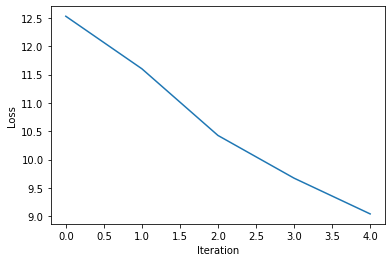

In [16]:
plotLoss(lossCounter)

In [17]:
model.resetMem(printOut=True)

oldMem.pt has been removed successfully!
Before Encoder LTR Memory : tensor([[[ 0.0933,  0.0963,  0.7623,  ...,  0.5612,  0.2442, -0.1147],
         [-0.0711,  0.0843,  0.6770,  ...,  0.8533, -0.0095, -0.6506],
         [ 0.1240,  0.1105,  0.6593,  ...,  0.7193, -0.0207, -0.5705],
         ...,
         [ 0.2205,  0.1322,  0.5336,  ...,  0.4417,  0.1669, -0.1969],
         [-0.0040,  0.1959,  0.5014,  ...,  0.8536, -0.0043, -0.1962],
         [ 0.2490, -0.1364,  0.7274,  ...,  0.9945,  0.1511, -0.3317]]],
       device='cuda:0')
After Encoder LTR update Memory : None


In [18]:
##### UNCOMMENT TO RESET MEMORY
# model.resetMem(printOut=True)
########

tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-en-ro", src_lang="en_XX", tgt_lang="ro_RO")
example_english_phrase = "UN Chief Says There Is No Military Solution in Syria"
expected_translation_romanian = "Şeful ONU declară că nu există o soluţie militară în Siria"

inputs = tokenizer(example_english_phrase, text_target=expected_translation_romanian, return_tensors="pt")
inputs = inputs.to(device)
model.to(device)
model.train()
# # forward pass
model(**inputs)


tensor(11.5802, device='cuda:0', grad_fn=<NllLossBackward0>)

In [20]:
model.resetMem(printOut=True)

Before Encoder LTR Memory : None
After Encoder LTR update Memory : None
